# Gender Gap Predictions
#### BSAN 6070, Spring 2025
#### Tina Brauneck | Henry Lissner | Ruben Rodriguez  <br>
Special Thanks to Matthew Chin, Ayato Arakaki, Anthony Hanna for their contributions during the Datathon

<br>Description: <br>This program uses ensemble models, including Random Forest, AdaBoost, Gradient Boost, and XGB to predict income. The process begins with data exploration and pre-processing. It includes hyperparameter tuning, using graphs to find the optimal value, as well as k-fold cross validation and GridSearchCV to find best combinations of values. The program compares the performance of the four different ensemble models, using the optimal n_estimators value for each. <br><br>

### Table of Contents
##### &emsp; Step 1: Data Exploration and Pre-processing

&emsp; &emsp; &emsp; Setup <br>
&emsp; &emsp; &emsp; Data Quality Report <br>
&emsp; &emsp; &emsp; Missing Data Checks <br>
&emsp; &emsp; &emsp; Cardinality Checks <br>
&emsp; &emsp; &emsp; Scatterplots <br>
&emsp; &emsp; &emsp; Bar Charts <br>
&emsp; &emsp; &emsp; Correlation <br>
&emsp; &emsp; &emsp; Pre-processing <br>

##### &emsp; Step 2: Modeling

&emsp; &emsp; &emsp; Model Setup <br>
&emsp; &emsp; &emsp; Gradient Boost <br>
&emsp; &emsp; &emsp; AdaBoost <br>
&emsp; &emsp; &emsp; XGB <br>
&emsp; &emsp; &emsp; Choosing the Model <br>

##### &emsp; Step 3: Predictor

&emsp; &emsp; &emsp; User Input <br>
&emsp; &emsp; &emsp; Prediction

 <br>

## Step 1: Data Exploration & Pre-processing

### Setup

Environment setup and package imports:

In [6]:
# Optional installations. Uncomment and install if not already installed. It is recommended that you run one line at a time.
# pip install plotnine pandas
## pip install plotly
# pip install girth
# pip install --upgrade bottleneck
# pip install semopy
# conda install python-graphviz
# pip install xgboost

In [ ]:
#Package imports:

# Basic visualization and data handling
import math 
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_histogram, facet_wrap, geom_bar
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Modeling
from sklearn import tree, metrics
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#Performance Visualization
from matplotlib.legend_handler import HandlerLine2D

These next few steps put our data into a dataframe and provide a first look at the data.

In [8]:
# Optional working directory set up. Change the path and uncomment lines below to change the working directory.
#import os
#os.chdir(r"C:\Users\ttesn\OneDrive\Documents\MSBA\BSAN 6070\Final Project")
#print(os.getcwd()) 

In [9]:
df = pd.read_csv("Sample ACS 2021 for LMU.csv", low_memory=False, encoding='latin1') # read in the data

In [10]:
df.dtypes # This function determines if the feature is categorial or numerical

REGION         object
STATEFIP       object
PERWT         float64
NCHILD         object
SEX            object
AGE            object
MARST          object
MARRNO         object
RACE           object
RACED          object
BPL            object
BPLD           object
ANCESTR1       object
ANCESTR1D      object
CITIZEN        object
YRNATUR        object
LANGUAGE       object
LANGUAGED      object
SPEAKENG       object
EDUC           object
EDUCD          object
DEGFIELD       object
DEGFIELDD      object
DEGFIELD2      object
DEGFIELD2D     object
EMPSTAT        object
EMPSTATD       object
CLASSWKR       object
CLASSWKRD      object
OCCSOC         object
IND             int64
WKSWORK1        int64
UHRSWORK       object
INCTOT          int64
INCWAGE         int64
INCINVST        int64
INCOTHER        int64
INCEARN        object
TRANWORK       object
TRANTIME        int64
DEPARTS         int64
ARRIVES         int64
dtype: object

In [11]:
df.head() #preview the data

REGION STATEFIP  PERWT              NCHILD     SEX AGE  \
0  East South Central Div.  Alabama   48.0  0 children present    Male  20   
1  East South Central Div.  Alabama    9.0  0 children present  Female  52   
2  East South Central Div.  Alabama   46.0  0 children present  Female  18   
3  East South Central Div.  Alabama   54.0  0 children present    Male  20   
4  East South Central Div.  Alabama   42.0  0 children present  Female  18   

                  MARST          MARRNO                    RACE  \
0  Never married/single  Not Applicable  Black/African American   
1  Never married/single  Not Applicable  Black/African American   
2  Never married/single  Not Applicable  Black/African American   
3  Never married/single  Not Applicable  Black/African American   
4  Never married/single  Not Applicable  Black/African American   

                    RACED  ... UHRSWORK INCTOT INCWAGE INCINVST INCOTHER  \
0  Black/African American  ...       40   6300    6300        0        0   
1  Black/African American  ...       40  40600   40600        0        0   
2  Black/African American  ...       41   6000    6000        0        0   
3  Black/African American  ...       40   6300    6300        0        0   
4  Black/African American  ...       35  26400   26400        0        0   

  INCEARN             TRANWORK TRANTIME DEPARTS ARRIVES  
0    6300  Auto, truck, or van        5    1915    1909  
1   40600  Auto, truck, or van        5     802     809  
2    6000  Auto, truck, or van       25     532     559  
3    6300  Auto, truck, or van        5    1915    1909  
4   26400          Walked only        3    1455    1459  

[5 rows x 42 columns]

In [12]:
## print the DataFrame's shape, i.e., number of rows and columns
print(df.shape)

(502363, 42)


##### Preliminary Cleaning

In [13]:
df.iloc[:, 15] = df.iloc[:,15].astype(str)

In [14]:
df = df[df['INCEARN'] != '$1 or breakeven']

In [15]:
df = df[df['AGE'] != '90 (90+ in 1980 and 1990)'] # Over 90 are extreme outliers. We will review other outliers in the outlier section.

In [16]:
df.tail() #preview the data

REGION STATEFIP  PERWT              NCHILD   SEX AGE  \
502358  Mountain Division  Wyoming  155.0                   2  Male  32   
502359  Mountain Division  Wyoming  186.0  0 children present  Male  23   
502360  Mountain Division  Wyoming  152.0  0 children present  Male  46   
502361  Mountain Division  Wyoming  160.0                   4  Male  42   
502362  Mountain Division  Wyoming   81.0  0 children present  Male  71   

                          MARST          MARRNO   RACE  RACED  ... UHRSWORK  \
502358  Married, spouse present    Married once  White  White  ...       40   
502359     Never married/single  Not Applicable  White  White  ...       50   
502360  Married, spouse present    Married once  White  White  ...       80   
502361  Married, spouse present    Married once  White  White  ...       40   
502362  Married, spouse present    Married once  White  White  ...       50   

        INCTOT INCWAGE INCINVST INCOTHER INCEARN             TRANWORK  \
502358   70000   70000        0        0   70000  Auto, truck, or van   
502359   20000   20000        0        0   20000  Auto, truck, or van   
502360   95000   95000        0        0   95000  Auto, truck, or van   
502361   44000   44000        0        0   44000  Auto, truck, or van   
502362  105500   65000        0        0   65000  Auto, truck, or van   

       TRANTIME DEPARTS ARRIVES  
502358       45     702     749  
502359       20     602     624  
502360       90     717     849  
502361       11     702     714  
502362       25     832     859  

[5 rows x 42 columns]

In [17]:
# fix type errors
df['INCEARN'] = df['INCEARN'].astype(int)

In [18]:
df['UHRSWORK'] = df['UHRSWORK'].replace('99 (Topcode)', 99)

In [19]:
df['UHRSWORK'] = df['UHRSWORK'].astype(int)

### Data Quality Report

In [20]:
# Setting display options so that the report will be readable
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [21]:
pd.set_option('display.width', 1000)

In [22]:
# Custom function for creating a data quality report

def data_quality_report(df, report_type):
    continuous_rows = []
    categorical_rows = []
    
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]): 
            count = df[col].count()
            missing_percentage = df[col].isnull().mean() * 100
            cardinality = df[col].nunique()
            first_quartile = df[col].quantile(0.25)
            mean = df[col].mean()
            median = df[col].median()
            third_quartile = df[col].quantile(0.75)
            max_value = df[col].max()
            std_dev = df[col].std()
            
            continuous_rows.append({
                'Feature': col,
                'Count': count,
                '% Missing': missing_percentage,
                'Card.': cardinality,
                '1st Qrt.': first_quartile,
                'Mean': mean,
                'Median': median,
                '3rd Qrt.': third_quartile,
                'Max': max_value,
                'Std. Dev.': std_dev
            })

        else:
            count = df[col].count()
            missing_percentage = df[col].isnull().mean() * 100
            cardinality = df[col].nunique()
            value_counts = df[col].value_counts()
            mode = value_counts.index[0] if not value_counts.empty else 'NA'
            mode_freq = value_counts.iloc[0] if not value_counts.empty else 0
            mode_percentage = (mode_freq / count) * 100 if count > 0 else 0
            second_mode = value_counts.index[1] if len(value_counts) > 1 else 'NA'
            second_mode_freq = value_counts.iloc[1] if len(value_counts) > 1 else 0
            second_mode_percentage = (second_mode_freq / count) * 100 if count > 0 else 0

            categorical_rows.append({
                'Feature': col,
                'Count': count,
                '% Missing': missing_percentage,
                'Card.': cardinality,
                'Mode': mode,
                'Mode Freq.': mode_freq,
                'Mode %': mode_percentage,
                '2nd Mode': second_mode,
                '2nd Mode Freq.': second_mode_freq,
                '2nd Mode %': second_mode_percentage
            })

    continuous_report = pd.DataFrame(continuous_rows)
    categorical_report = pd.DataFrame(categorical_rows)

    if report_type == "cont":
        return continuous_report

    elif report_type == "cat":
        return categorical_report
        
    else:
        raise ValueError("Error: report type options are 'cat' or 'cont'")

In [23]:
dqr_cont = data_quality_report(df,"cont")

In [24]:
dqr_cat = data_quality_report(df,"cat")

#### Data Quality Report: Continuous Features

In [25]:
dqr_cont

Feature   Count  % Missing  Card.  1st Qrt.          Mean   Median  3rd Qrt.        Max     Std. Dev.
0      PERWT  502351        0.0   1055      53.0    107.670481     81.0     131.0     2471.0     92.228337
1        IND  502351        0.0    262    4580.0   6175.749587   7270.0    8090.0     9590.0   2667.680874
2   WKSWORK1  502351        0.0      3      52.0     51.980297     52.0      52.0       52.0      0.190681
3   UHRSWORK  502351        0.0     65      40.0     43.785680     40.0      45.0       99.0      8.127149
4     INCTOT  502351        0.0  11356   36000.0  80917.803323  58000.0   92500.0  1487400.0  87420.851281
5    INCWAGE  502351        0.0    935   33000.0  73130.686548  53000.0   86000.0   787000.0  78261.979196
6   INCINVST  502351        0.0    695       0.0   1772.902799      0.0       0.0   522000.0  17421.603196
7   INCOTHER  502351        0.0    500       0.0    352.595576      0.0       0.0    76000.0   2869.521959
8    INCEARN  502351        0.0   2952   35000.0  77084.471348  55000.0   90000.0  1174000.0  81843.688696
9   TRANTIME  502351        0.0    141       5.0     21.224373     15.0      30.0      163.0     22.362604
10   DEPARTS  502351        0.0    151     502.0    627.605541    702.0     802.0     2345.0    433.009431
11   ARRIVES  502351        0.0    286     519.0    657.885906    719.0     824.0     2359.0    442.540948

This is our target feature.

#### Data Quality Report: Categorical Features

In [26]:
dqr_cat

Feature   Count  % Missing  Card.                                    Mode  Mode Freq.      Mode %                                2nd Mode  2nd Mode Freq.  2nd Mode %
0       REGION  502351   0.000000      9                 South Atlantic Division      100183   19.942829                        Pacific Division           78363   15.599252
1     STATEFIP  502351   0.000000     51                              California       57369   11.420103                                   Texas           41287    8.218755
2       NCHILD  502351   0.000000     10                      0 children present      276512   55.043585                         1 child present           97426   19.394009
3          SEX  502351   0.000000      2                                    Male      281125   55.961867                                  Female          221226   44.038133
4          AGE  502351   0.000000     79                                      50       12845    2.556977                                      51           12205    2.429576
5        MARST  502351   0.000000      6                 Married, spouse present      294021   58.528997                    Never married/single          129511   25.780978
6       MARRNO  502351   0.000000      4                            Married once      294301   58.584735                          Not Applicable          129511   25.780978
7         RACE  502351   0.000000      9                                   White      341661   68.012406                         Two major races           47348    9.425282
8        RACED  502351   0.000000    139                                   White      341661   68.012406                  Black/African American           40424    8.046963
9          BPL  502351   0.000000    123                              California       41015    8.164610                                New York           32309    6.431559
10        BPLD  502351   0.000000    219                              California       41015    8.164610                                New York           32309    6.431559
11    ANCESTR1  502351   0.000000    206                            Not Reported       94821   18.875448                                  German           57071   11.360782
12   ANCESTR1D  502351   0.000000    233                            Not Reported       94821   18.875448            German (1990-2000, ACS/PRCS)           56682   11.283346
13     CITIZEN   85008  83.077967      3                     Naturalized citizen       46195   54.341944                           Not a citizen           33234   39.095144
14     YRNATUR  502351   0.000000     75                                     nan      456156   90.804238                                    2019            1942    0.386582
15    LANGUAGE  502351   0.000000     63                                 English      401519   79.927979                                 Spanish           55325   11.013216
16   LANGUAGED  502351   0.000000    115                                 English      401296   79.883587                                 Spanish           55325   11.013216
17    SPEAKENG  502351   0.000000      5                Yes, speaks only English      401296   79.883587                   Yes, speaks very well           65853   13.108962
18        EDUC  502351   0.000000     11                                Grade 12      149740   29.807844                      4 years of college          131823   26.241214
19       EDUCD  502351   0.000000     24                       Bachelor's degree      131823   26.241214             Regular high school diploma           96498   19.209278
20    DEGFIELD  221121  55.982769     37                                Business       47582   21.518535                             Engineering           20826    9.418373
21   DEGFIELDD  221121  55.982769    172  Business Management and Administration       13593    6.147313                        General Business            9743    4.406185
22   DEGFIELD2   25203  94.9

#### Missing Data Checks

Show features with more than 60% of observations missing data.

In [27]:
dqr_cat[dqr_cat['% Missing'] > 60]

Feature  Count  % Missing  Card.                 Mode  Mode Freq.     Mode %                                2nd Mode  2nd Mode Freq.  2nd Mode %
13     CITIZEN  85008  83.077967      3  Naturalized citizen       46195  54.341944                           Not a citizen           33234   39.095144
22   DEGFIELD2  25203  94.982990     37             Business        4831  19.168353                         Social Sciences            2945   11.685117
23  DEGFIELD2D  25203  94.982990    171           Psychology        1021   4.051105  Business Management and Administration            1014    4.023331

In [28]:
df.loc[:,['DEGFIELD', 'DEGFIELDD', 'DEGFIELD2', 'DEGFIELD2D']].tail(25)

DEGFIELD                             DEGFIELDD   DEGFIELD2  DEGFIELD2D
502338                                       NaN                                   NaN         NaN         NaN
502339                                       NaN                                   NaN         NaN         NaN
502340                                       NaN                                   NaN         NaN         NaN
502341                                       NaN                                   NaN         NaN         NaN
502342                           Social Sciences                             Sociology         NaN         NaN
502343                               Engineering                  Chemical Engineering         NaN         NaN
502344                                       NaN                                   NaN         NaN         NaN
502345                                       NaN                                   NaN         NaN         NaN
502346  Medical and Health Sciences and Services                               Nursing         NaN         NaN
502347      Criminal Justice and Fire Protection  Criminal Justice and Fire Protection  Psychology  Psychology
502348                                       NaN                                   NaN         NaN         NaN
502349                                       NaN                                   NaN         NaN         NaN
502350                                       NaN                                   NaN         NaN         NaN
502351  Medical and Health Sciences and Services            Medical Assisting Services         NaN         NaN
502352                                       NaN                                   NaN         NaN         NaN
502353                                       NaN                                   NaN         NaN         NaN
502354               Liberal Arts and Humanities                          Liberal Arts         NaN         NaN
502355                                       NaN                                   NaN         NaN         NaN
502356                                       NaN                                   NaN         NaN         NaN
502357      Criminal Justice and Fire Protection  Criminal Justice and Fire Protection         NaN         NaN
502358                                       NaN                                   NaN         NaN         NaN
502359                                       NaN                                   NaN         NaN         NaN
502360                                       NaN                                   NaN         NaN         NaN
502361                                  Business                      General Business         NaN         NaN
502362          Philosophy and Religious Studies      Philosophy and Religious Studies         NaN         NaN

Looks like DEGFIELD is more general than DEGFIELDD. Likewise, DEGFIELD2 is more general than DEGFIELD2D. We will drop one set.

In [29]:
dqr_cont[dqr_cont['% Missing'] > 60]

Empty DataFrame
Columns: [Feature, Count, % Missing, Card., 1st Qrt., Mean, Median, 3rd Qrt., Max, Std. Dev.]
Index: []

There is no missing data in this dataset.

#### Cardinality Checks

Next, we check for unusually high or low cardinality.

In [30]:
# Checking for features with a cardinality of 1. 
# If a feature has cardinality of 1, we drop it, because it has no use; all the values are the same.
dqr_cat[dqr_cat['Card.'] == 1]

Feature   Count  % Missing  Card.      Mode  Mode Freq.  Mode % 2nd Mode  2nd Mode Freq.  2nd Mode %
24   EMPSTAT  502351        0.0      1  Employed      502351   100.0       NA               0         0.0
25  EMPSTATD  502351        0.0      1   At work      502351   100.0       NA               0         0.0

In [31]:
# Same check for the continuous features
dqr_cont[dqr_cont['Card.'] == 1]

Empty DataFrame
Columns: [Feature, Count, % Missing, Card., 1st Qrt., Mean, Median, 3rd Qrt., Max, Std. Dev.]
Index: []

In [32]:
# Checking for continuous features that have too low a cardinality. These may actually be encoded categorical features.
dqr_cont[dqr_cont['Card.'] < 30]

Feature   Count  % Missing  Card.  1st Qrt.       Mean  Median  3rd Qrt.   Max  Std. Dev.
2  WKSWORK1  502351        0.0      3      52.0  51.980297    52.0      52.0  52.0   0.190681

This is our target column and it has a binary encoding of 0 and 1.

In [33]:
# Assign any encoded categorical columns to cont_convert so they are graphed as if they are categorical.
cont_convert = 'y'

In [34]:
# Checking for categorical features that have too high a cardinality. These may just be unique identifiers and can be dropped.
dqr_cat[dqr_cat['Card.'] > 50]

Feature   Count  % Missing  Card.                                    Mode  Mode Freq.     Mode %                                2nd Mode  2nd Mode Freq.  2nd Mode %
1     STATEFIP  502351   0.000000     51                              California       57369  11.420103                                   Texas           41287    8.218755
4          AGE  502351   0.000000     79                                      50       12845   2.556977                                      51           12205    2.429576
8        RACED  502351   0.000000    139                                   White      341661  68.012406                  Black/African American           40424    8.046963
9          BPL  502351   0.000000    123                              California       41015   8.164610                                New York           32309    6.431559
10        BPLD  502351   0.000000    219                              California       41015   8.164610                                New York           32309    6.431559
11    ANCESTR1  502351   0.000000    206                            Not Reported       94821  18.875448                                  German           57071   11.360782
12   ANCESTR1D  502351   0.000000    233                            Not Reported       94821  18.875448            German (1990-2000, ACS/PRCS)           56682   11.283346
14     YRNATUR  502351   0.000000     75                                     nan      456156  90.804238                                    2019            1942    0.386582
15    LANGUAGE  502351   0.000000     63                                 English      401519  79.927979                                 Spanish           55325   11.013216
16   LANGUAGED  502351   0.000000    115                                 English      401296  79.883587                                 Spanish           55325   11.013216
21   DEGFIELDD  221121  55.982769    172  Business Management and Administration       13593   6.147313                        General Business            9743    4.406185
23  DEGFIELD2D   25203  94.982990    171                              Psychology        1021   4.051105  Business Management and Administration            1014    4.023331
28      OCCSOC  502351   0.000000    525                                  1191XX       18454   3.673527                                  291141           11768    2.342585

Our features are binned, so, as expected, they all have relatively low cadinality.

In [35]:
# Make a copy of the dataframe and assign it as our analytics base table (abt). The original df will remain unaltered.
abt=df.copy()

### Data Exploration

To start exploring, we divide the ABT dataframe into two feature sets: continuous features and categorical features.

In [36]:
cont_convert = [] # use to declare any continuous columns that should behave like categorical columns, e.g., encoded categorical columns

In [37]:
# Declare empty lists for the categorical columns and the continuous columns
def define_column_types(df):
    categorical_cols = []
    continuous_cols = []

    #Define continuous and categorial columns from the abt:
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            continuous_cols.append(col)
        else:
            categorical_cols.append(col)

    # Transfer any continous columns that were identified as encoded categorical columns in the cardinality checks.
    if len(cont_convert) >0:
        continuous_cols.remove(cont_convert)
        categorical_cols.append(cont_convert)
    return continuous_cols, categorical_cols

In [38]:
continuous_cols, categorical_cols = define_column_types(df=abt)

In [39]:
# Check the output
abt[categorical_cols].head()

REGION STATEFIP              NCHILD     SEX AGE                 MARST          MARRNO                    RACE                   RACED      BPL     BPLD          ANCESTR1                                ANCESTR1D CITIZEN YRNATUR LANGUAGE LANGUAGED                  SPEAKENG               EDUC                                         EDUCD DEGFIELD DEGFIELDD DEGFIELD2 DEGFIELD2D   EMPSTAT EMPSTATD         CLASSWKR             CLASSWKRD  OCCSOC             TRANWORK
0  East South Central Div.  Alabama  0 children present    Male  20  Never married/single  Not Applicable  Black/African American  Black/African American  Georgia  Georgia  African-American  African-American (1990-2000, ACS, PRCS)     NaN     nan  English   English  Yes, speaks only English  1 year of college  1 or more years of college credit, no degree      NaN       NaN       NaN        NaN  Employed  At work  Works for wages  Wage/salary, private  399041  Auto, truck, or van
1  East South Central Div.  Alabama  0 children present  Female  52  Never married/single  Not Applicable  Black/African American  Black/African American  Alabama  Alabama  African-American  African-American (1990-2000, ACS, PRCS)     NaN     nan  English   English  Yes, speaks only English           Grade 12                   Regular high school diploma      NaN       NaN       NaN        NaN  Employed  At work  Works for wages  Wage/salary, private  537051  Auto, truck, or van
2  East South Central Div.  Alabama  0 children present  Female  18  Never married/single  Not Applicable  Black/African American  Black/African American  Alabama  Alabama  African-American  African-American (1990-2000, ACS, PRCS)     NaN     nan  English   English  Yes, speaks only English           Grade 12            Some college, but less than 1 year      NaN       NaN       NaN        NaN  Employed  At work  Works for wages   State govt employee  412010  Auto, truck, or van
3  East South Central Div.  Alabama  0 children present    Male  20  Never married/single  Not Applicable  Black/African American  Black/African American  Georgia  Georgia  African-American  African-American (1990-2000, ACS, PRCS)     NaN     nan  English   English  Yes, speaks only English  1 year of college  1 or more years of college credit, no degree      NaN       NaN       NaN        NaN  Employed  At work  Works for wages  Wage/salary, private  399041  Auto, truck, or van
4  East South Central Div.  Alabama  0 children present  Female  18  Never married/single  Not Applicable  Black/African American  Black/African American  Florida  Florida  African-American  African-American (1990-2000, ACS, PRCS)     NaN     nan  English   English  Yes, speaks only English           Grade 12            Some college, but less than 1 year      NaN       NaN       NaN        NaN  Employed  At work  Works for wages  Wage/salary, private  352010          Walked only

In [40]:
# Check the output
abt[continuous_cols].head()

PERWT   IND  WKSWORK1  UHRSWORK  INCTOT  INCWAGE  INCINVST  INCOTHER  INCEARN  TRANTIME  DEPARTS  ARRIVES
0   48.0  7870        52        40    6300     6300         0         0     6300         5     1915     1909
1    9.0  6390        52        40   40600    40600         0         0    40600         5      802      809
2   46.0  5391        52        41    6000     6000         0         0     6000        25      532      559
3   54.0  7870        52        40    6300     6300         0         0     6300         5     1915     1909
4   42.0  8680        52        35   26400    26400         0         0    26400         3     1455     1459

#### 3A. Data Distribution

##### Histograms

In [41]:
from plotnine import ggplot, aes, geom_histogram, facet_wrap, theme, element_text, theme_classic, scale_y_continuous

# Melt the DataFrame to long format
abt_cont_melted = abt[continuous_cols].melt(var_name='column', value_name='value')

# Calculate the number of rows and columns for the facet grid
n_cols = 4
n_rows = math.ceil(len(continuous_cols) / n_cols)

# Create the plot
cont_plot = (ggplot(abt_cont_melted, aes(x='value')) +
    geom_histogram(bins=20, fill='deepskyblue', color='black', size=0.1) +  # Add thin line around bars
    facet_wrap('~column', nrow=n_rows, ncol=n_cols, scales='free_x') +
    theme_classic() +  # Apply classic theme
    theme(panel_spacing=0.03,  # Adjust the spacing between panels
        figure_size=(80/n_cols, n_rows * 4),  # Dynamically set figure size based on number of columns and rows
        strip_text_x=element_text(size=10),
        axis_text=element_text(size=8)  # Adjust axis text size for a tighter layout
        #axis_title=element_text(size=10),  # Option to increase axis title size
        #plot_title=element_text(size=12)  # Option to increase plot title size
                 ) +
    scale_y_continuous(expand=(0, 0))  # Force the y-axis to start at zero
)

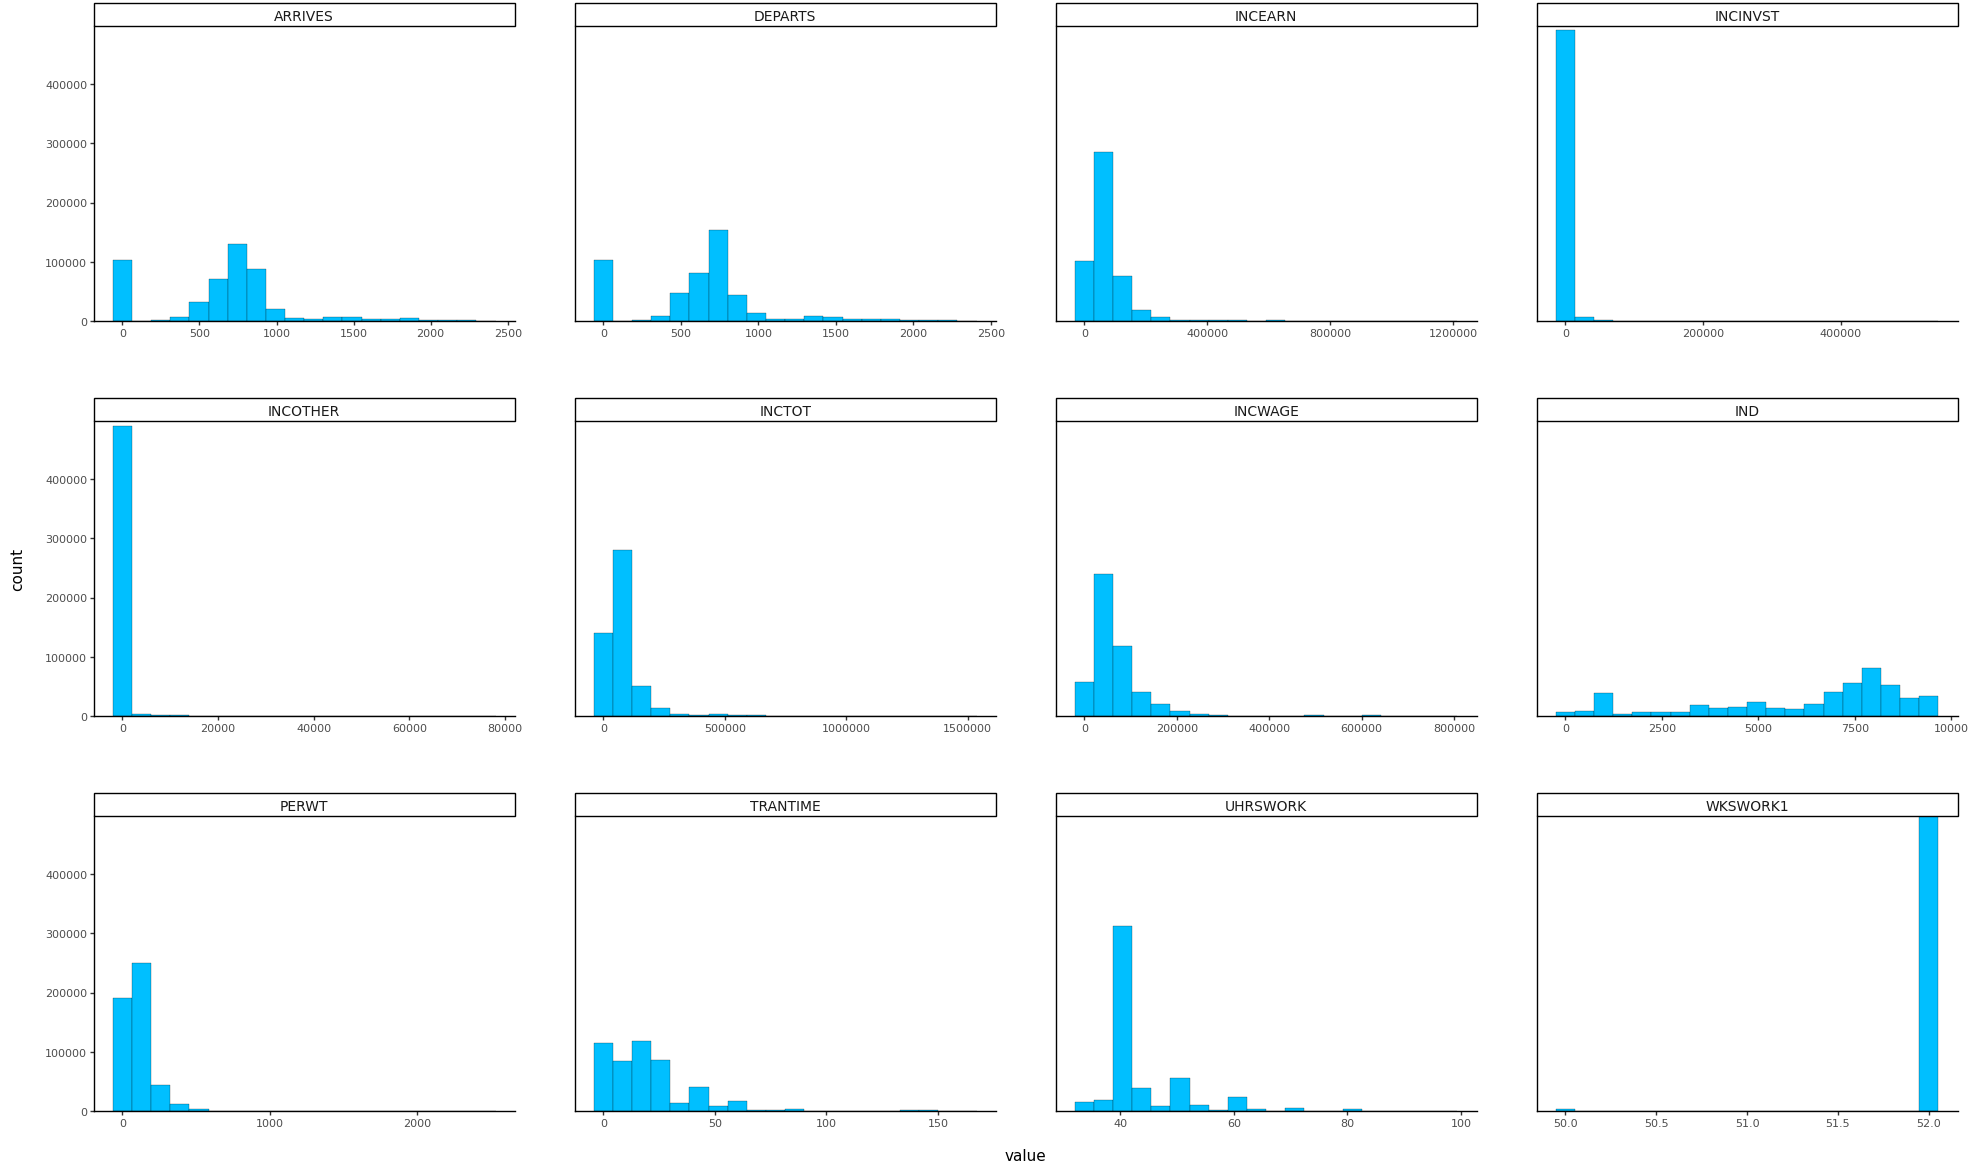

In [42]:
cont_plot.draw()

#### Bar Plots

Bar plots to visualize categorical columns. We will only visualize those with low-medium cardinality.

In [43]:
small_cat = dqr_cat.loc[dqr_cat['Card.'] < 30, 'Feature'].tolist()
small_cat.remove('EMPSTAT')
small_cat.remove('EMPSTATD')

In [44]:
from plotnine import (
    ggplot, aes, geom_bar, facet_wrap, theme_classic, theme, element_text, ggsave)

# Melt categorical columns for visualization
abt_cat_melted = abt[small_cat].melt(var_name='column', value_name='value')

# Design bar plots 
cat_plot = (
    ggplot(abt_cat_melted, aes(x='value')) +
    geom_bar(fill='deepskyblue', color='black', size=0.1) +  # Add thin line around bars
    facet_wrap('~column', nrow=12, ncol=3, scales='free_x') +
    theme_classic() +  # Apply classic theme
    theme(
        panel_spacing=0.005,  # Adjust space between panels
        figure_size=(20, 30),  # Increase the figure size (width, height)
        strip_text_x=element_text(size=8),  # Increase facet label size
        axis_text_x=element_text(size=9, angle=20),
        axis_text=element_text(size=8),  # Increase axis text size
        axis_title=element_text(size=11),  # Adjust axis title size
        # plot_title=element_text(size=36)  # Uncomment for plot title size
    )
)

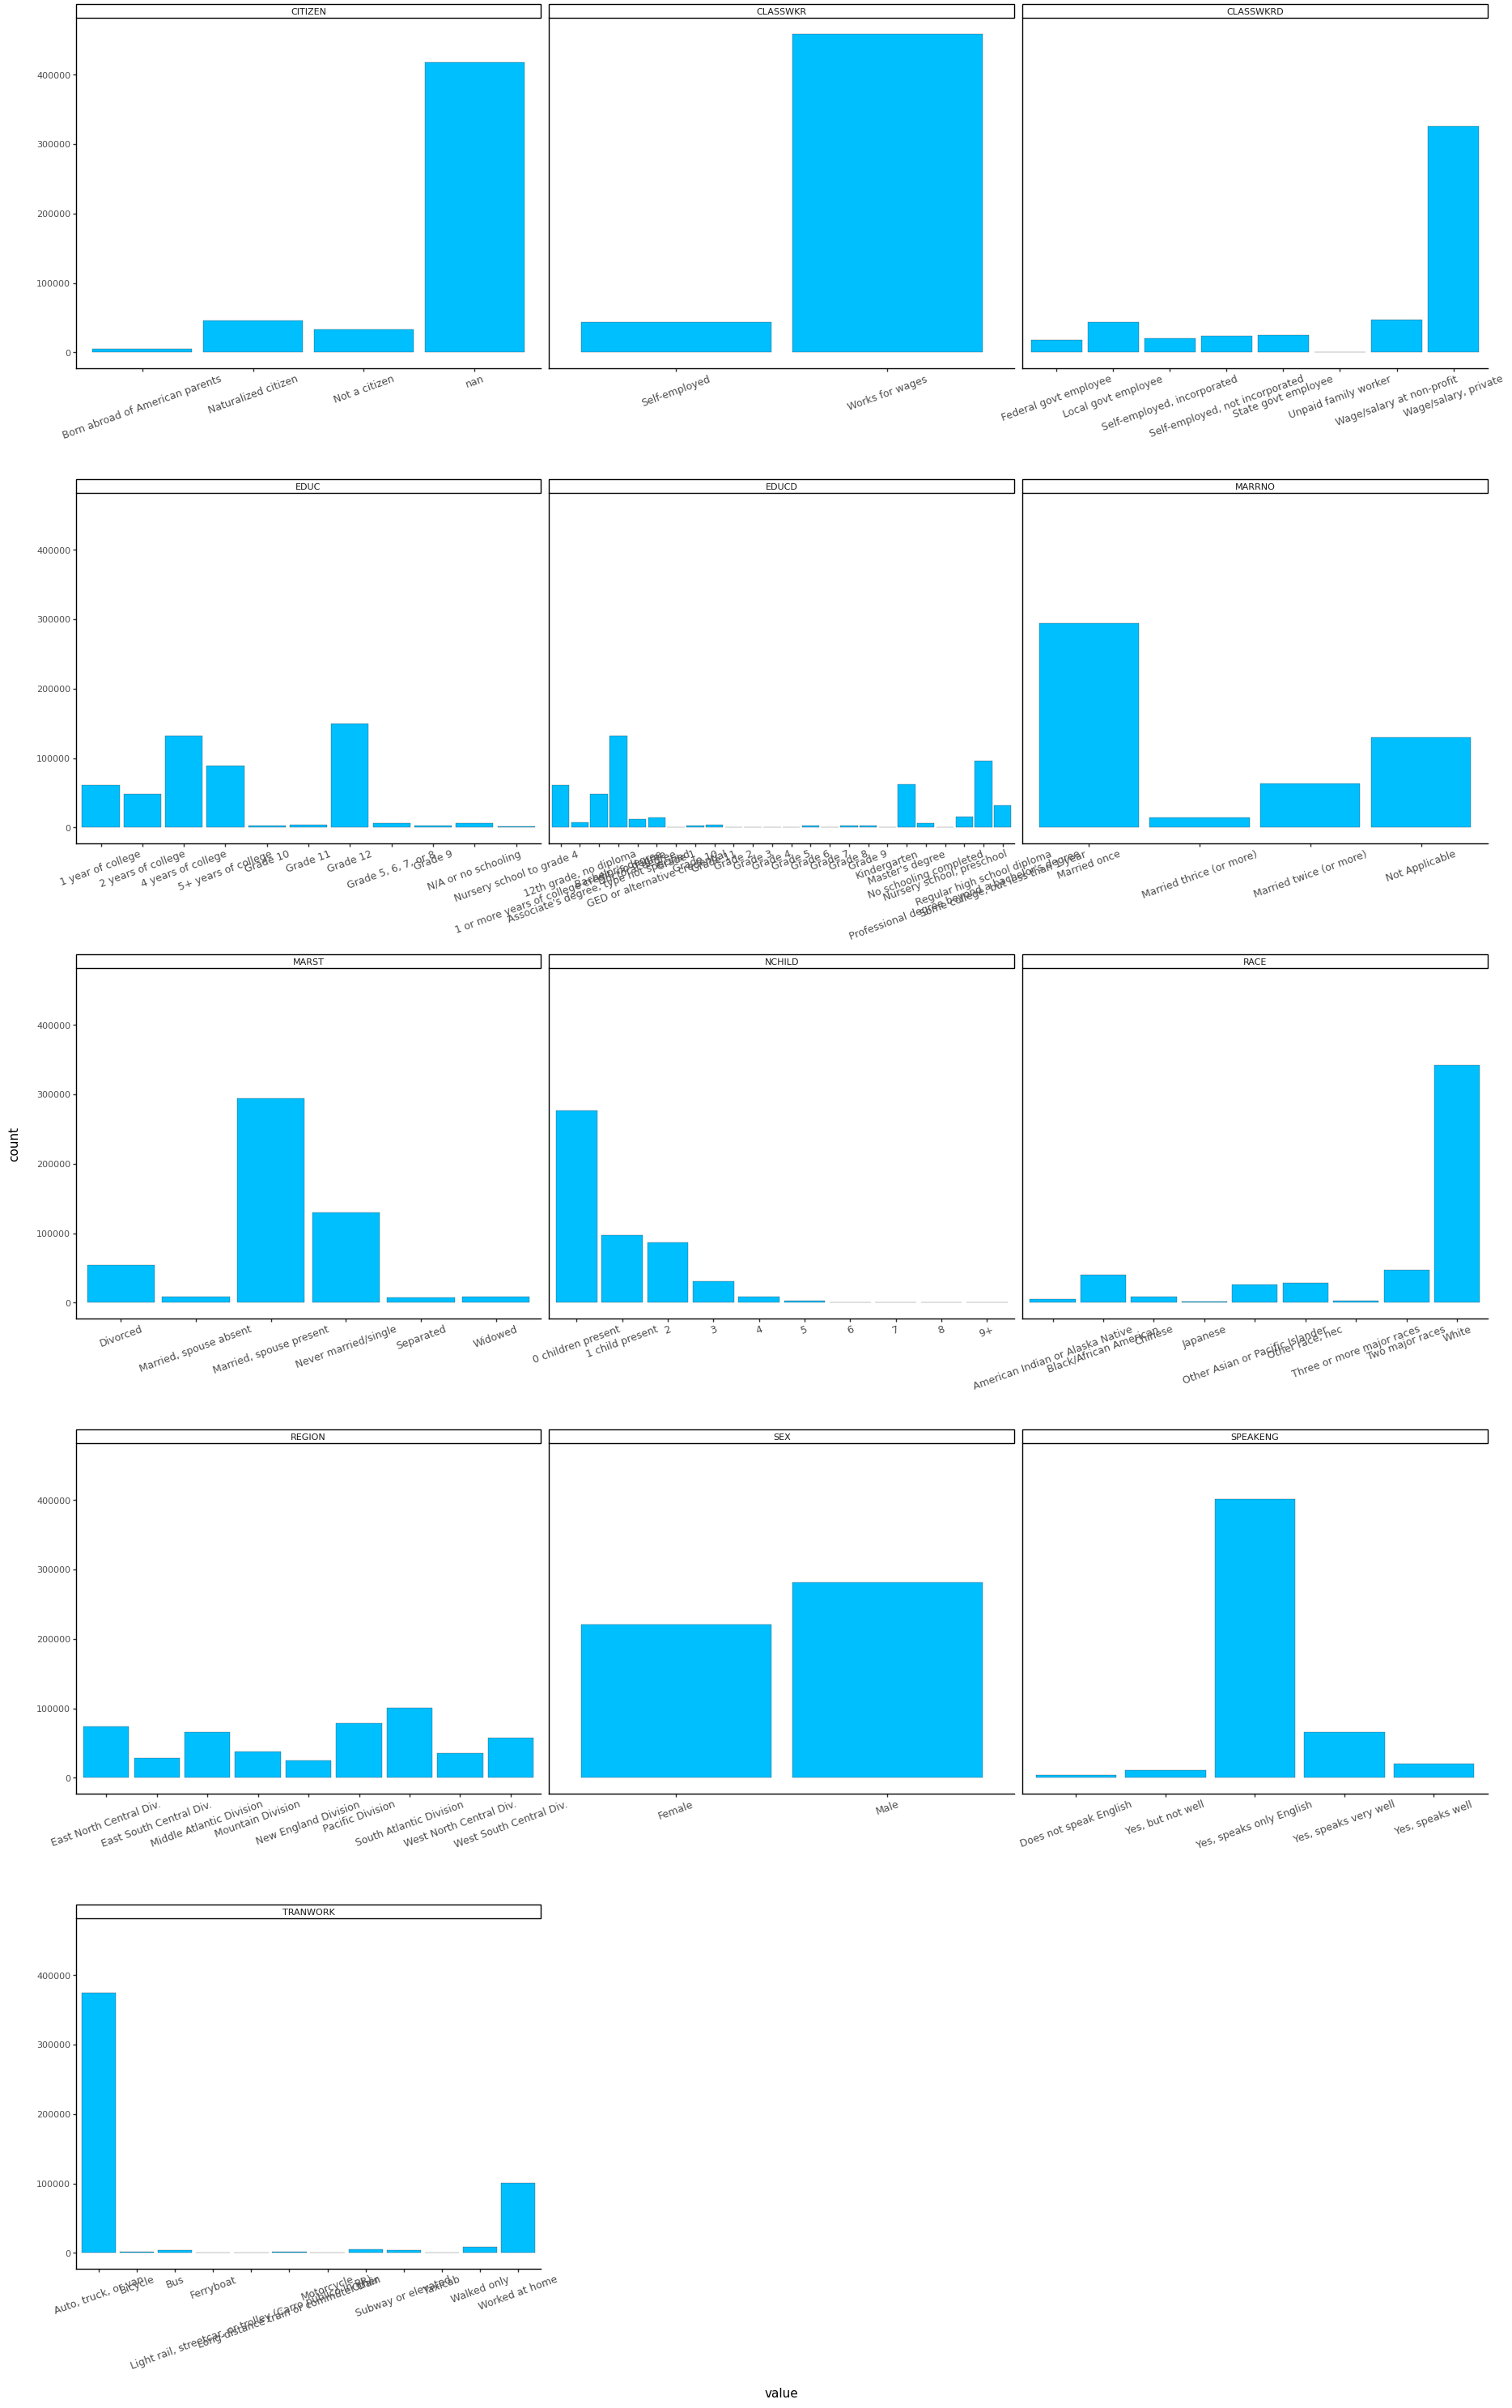

In [45]:
cat_plot.draw()

##### Bar Plots By Class and Feature

Next, we explore relationships in our data by comparing the fequency of out target class to the fequency of those outside that class, across different features.

In [46]:
# TBD - target column to be identified

In [47]:
# Melt categorical columns for visualization
abt_cat_melted = abt.melt(id_vars=['INCEARN'], value_vars=categorical_cols, var_name='column', value_name='value')

# Design bar plots 
y_plot = (
    ggplot(abt_cat_melted, aes(x='value', fill='factor(EDUC)')) +
    geom_bar(position='dodge', color='black', size=0.1) +  # Add thin line around bars
    facet_wrap('~column', nrow=12, ncol=3, scales='free_x') +
    theme_classic() +  # Apply classic theme
    theme(
        panel_spacing=0.005,  # Adjust space between panels
        figure_size=(10, 12),  # Increase the figure size (width, height)
        strip_text_x=element_text(size=8),  # Increase facet label size
        axis_text_x=element_text(size=9, angle=20),
        axis_text=element_text(size=8),  # Increase axis text size
        axis_title=element_text(size=11),  # Adjust axis title size
    )
)

In [48]:
#y_plot.draw()

Optional Comment

## Relationships

##### Scatterplots

In [49]:
## create a pairplot to visualize the relationships between multiple numeric columns
# This may take a while to render and will not show in the GitHub Preview. Uncomment to run this in JupyterLab.
sns.pairplot(abt[continuous_cols])

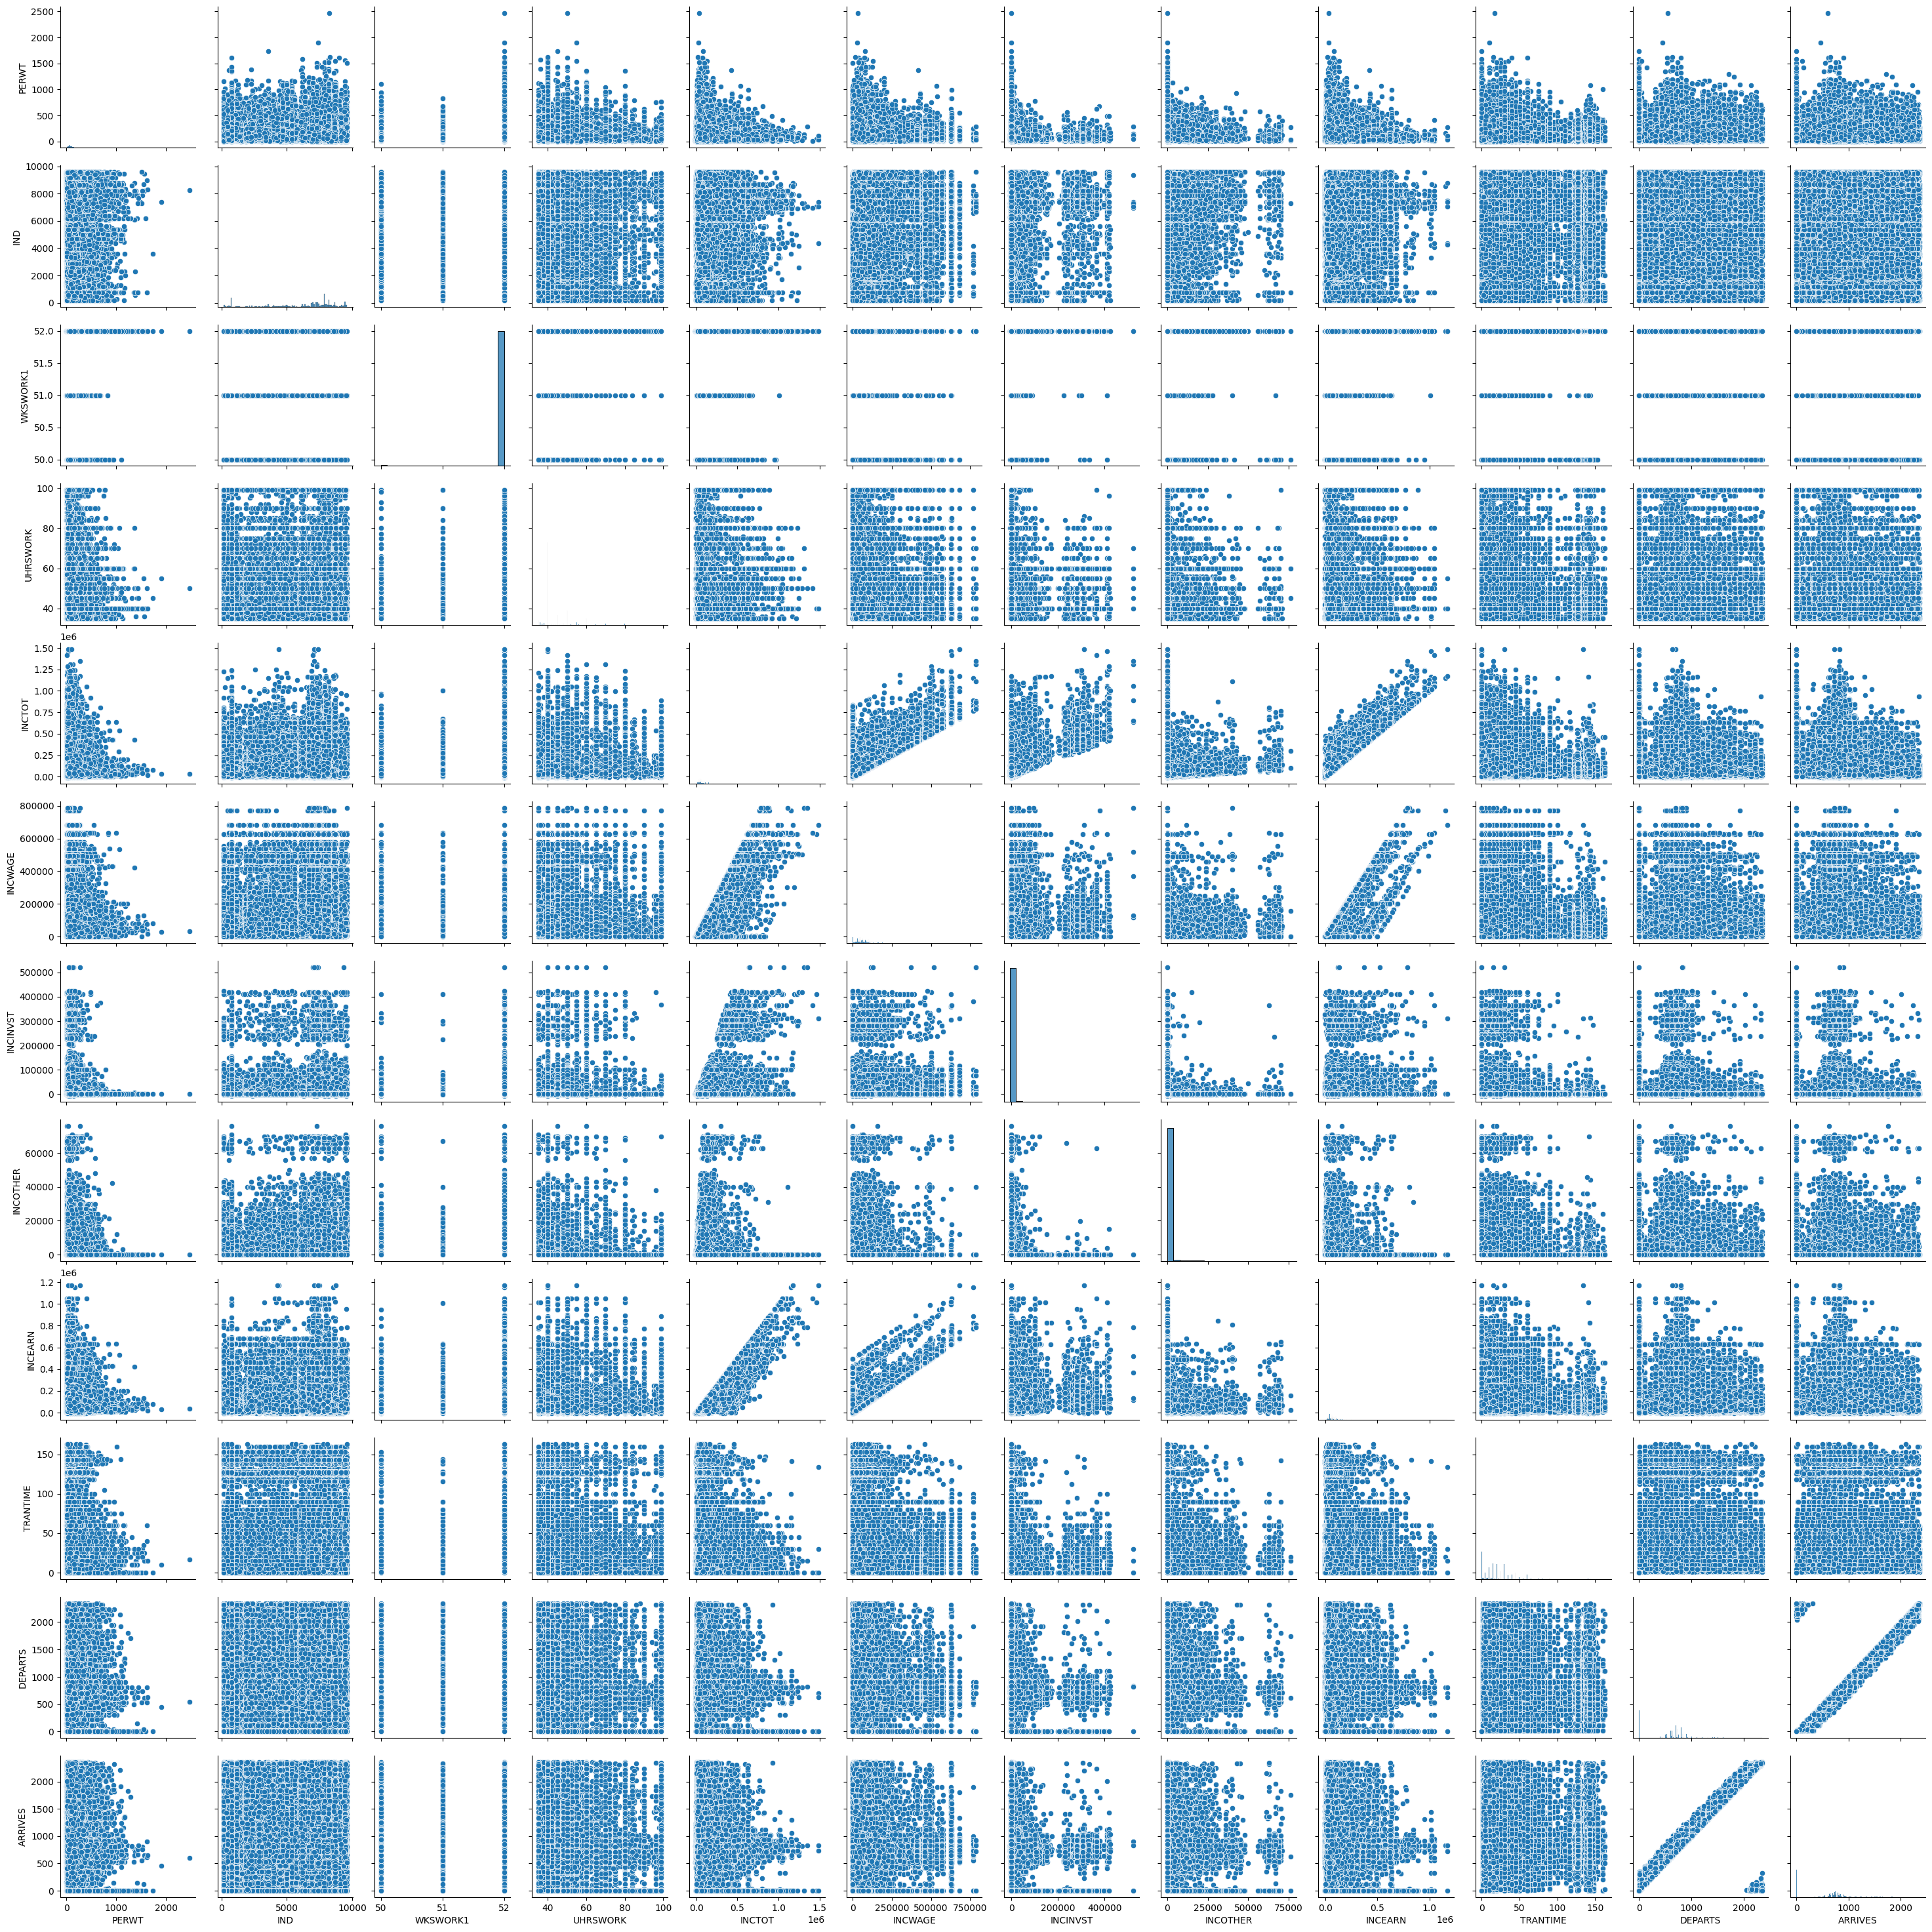

In [50]:
plt.show()

Based on the shape of PERWT and INCTOT, the distribution of income is wider when a person's weight is lower. We should be cautious about using this feature, however, because income can affect the food available, i.e., fast food rather than healthy food. The causal relationaship is in the opposite direction from what would be needed to PREDICT income. The same is true about transit time.

##### Correlation

In [51]:
correlation_matrix = abt[continuous_cols].corr()

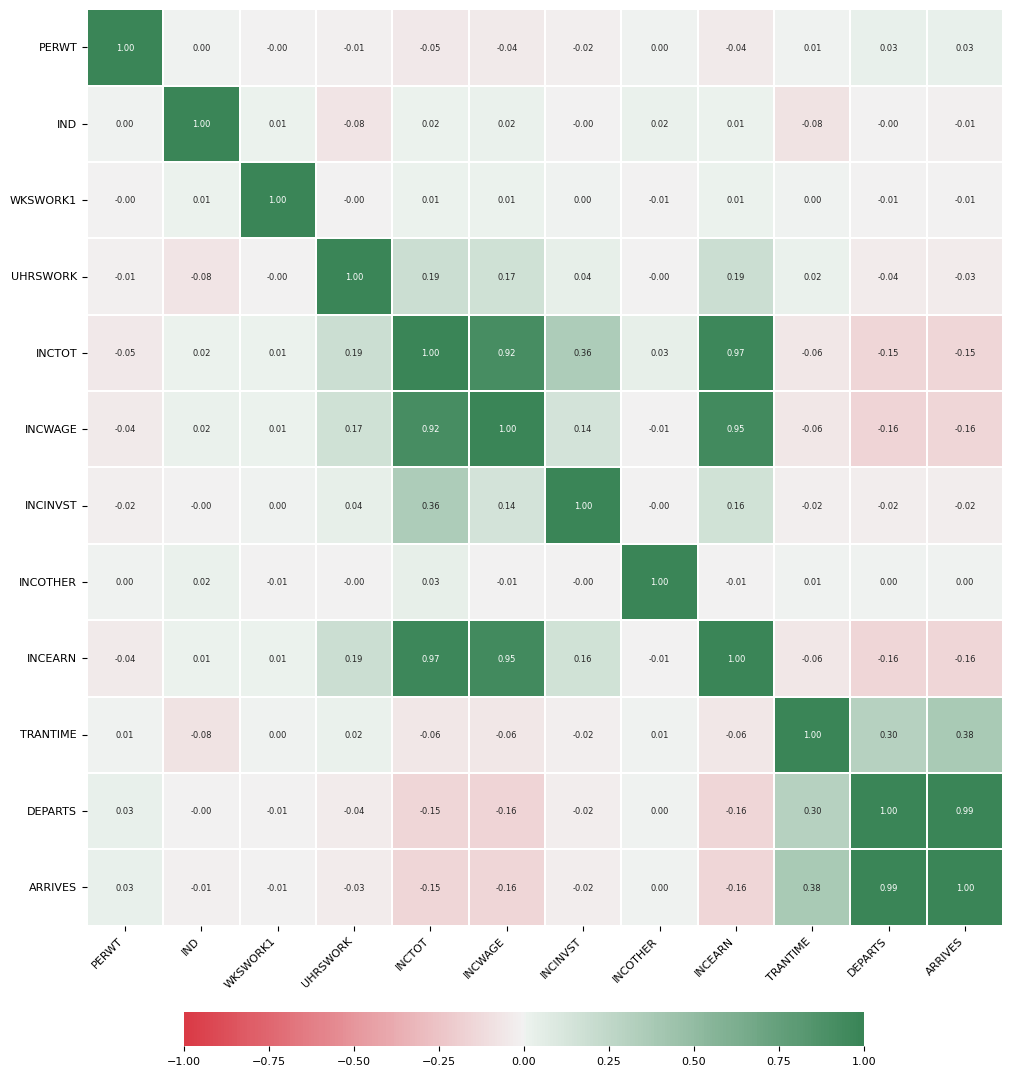

In [52]:
plt.figure(figsize=(17, 17))

axis_corr = sns.heatmap(
correlation_matrix,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(10, 500, n=500),
    square=True,
    annot=True,  # Show correlation coefficients in each square
    fmt=".2f", # Format the coefficients to 2 decimal places
    annot_kws={"size": 6},  # Set font size for correlation coefficients
    linewidths=.1,  # Add lines between squares for better visibility
    cbar_kws={"shrink": .60, "orientation": "horizontal"}  # Adjust color bar (legend) size
)

# Sets the font size and rotation for the x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Adjust the position of the color legend
cbar = axis_corr.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_position([0.2, 0.27, 0.6, 0.02])

#for text in axis_corr.texts:
    #text.set_visible(True)

plt.show()

In [53]:
# Now we create a filtered correlation matrix that only shows features with moderate to strong correlations.
# This doesn't mean all correlations shown are strong, but that features with only weak correlations have been removed for readability.

filtered_corr_matrix = correlation_matrix.copy()
for col in correlation_matrix.columns:
    if ((correlation_matrix[col].abs() <= 0.4).all()) or ((correlation_matrix[col].abs() <= 0.4).sum() == len(correlation_matrix) - 1):
        filtered_corr_matrix.drop(col, axis=1, inplace=True)
        filtered_corr_matrix.drop(col, axis=0, inplace=True)

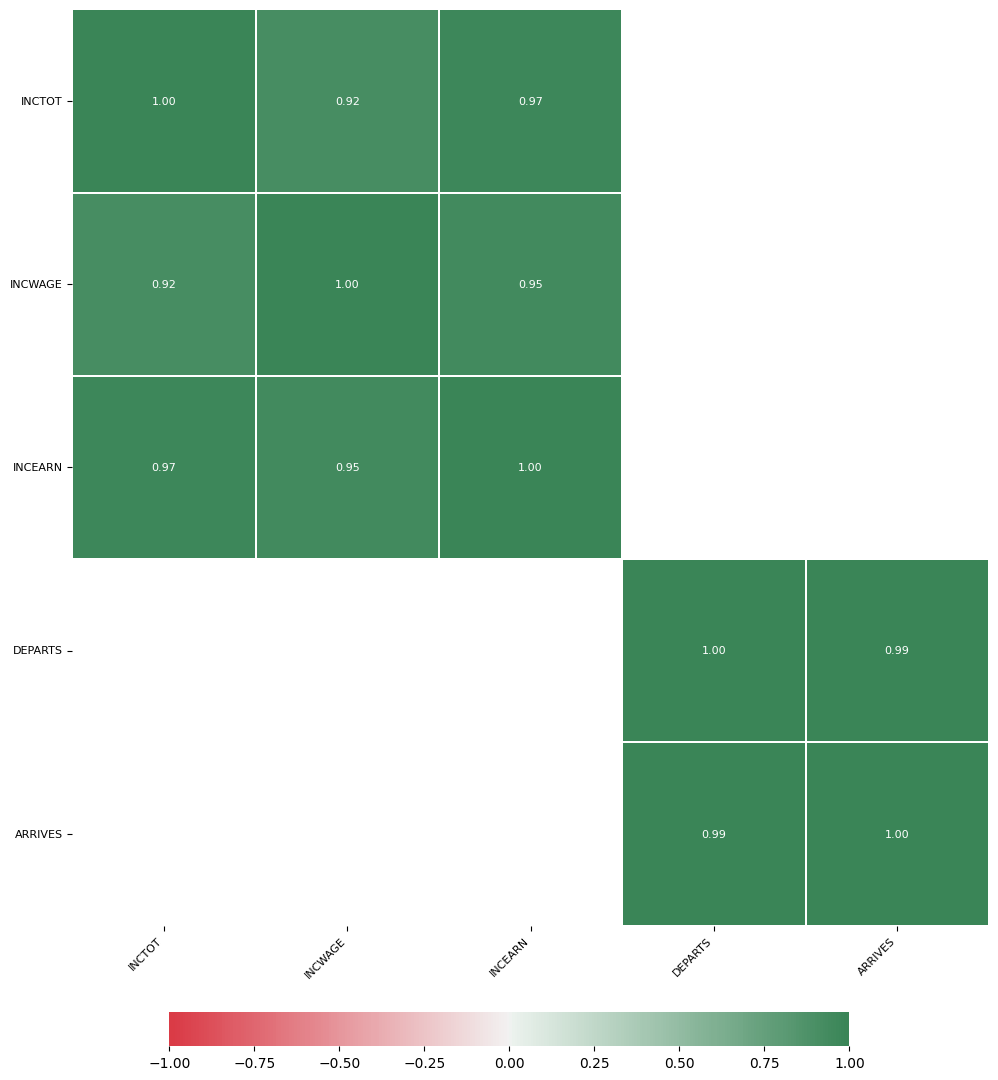

In [54]:
# visualizing correlations >.4

plt.figure(figsize=(17, 17))

axis_corr = sns.heatmap(
filtered_corr_matrix[filtered_corr_matrix.abs() > .4],
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(10, 500, n=500),
    square=True,
    annot=True,  # Show correlation coefficients in each square
    fmt=".2f", # Format the coefficients to 2 decimal places
    annot_kws={"size": 8},  # Set font size for correlation coefficients
    linewidths=.1, # Add lines between squares for better visibility
    cbar_kws={"shrink": .60, "orientation": "horizontal"}  # Adjust color bar (legend) size
)

# Sets the font size and rotation for the x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Adjust the position of the color legend
cbar = axis_corr.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_position([0.2, 0.27, 0.6, 0.02])

#for text in axis_corr.texts:
    #text.set_visible(True)

plt.show()

Very high multicollinearity on some features

<br>

### Cramer's V Correlation Matrix

In order to understand the relationship between features, we will use a correlation matrix. Cramer's matrix is suitable for categorical variables and ranges from 0 (no association) to 1 (high association).

In [55]:
def cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))  # Cross table building
    if crosstab.size == 0:
        return 0  # Handle empty cross table
    stat = chi2_contingency(crosstab)[0]  # Keeping the test statistic of the Chi2 test
    obs = np.sum(crosstab)  # Number of observations
    mini = min(crosstab.shape) - 1  # Take the minimum value between the columns and the rows of the cross table
    if mini == 0 or obs == 0:
        return 0  # Handle division by zero
    return np.sqrt(stat / (obs * mini))

In [56]:
from scipy.stats import chi2_contingency

rows = []

for var1 in abt[categorical_cols]:
    col = []
    for var2 in abt[categorical_cols]:
        cramers = cramers_V(abt[categorical_cols][var1], abt[categorical_cols][var2])  # Cramer's V test
        col.append(round(cramers, 2))  # Keeping the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)
matrix = pd.DataFrame(cramers_results, columns=abt[categorical_cols].columns, index=abt[categorical_cols].columns)


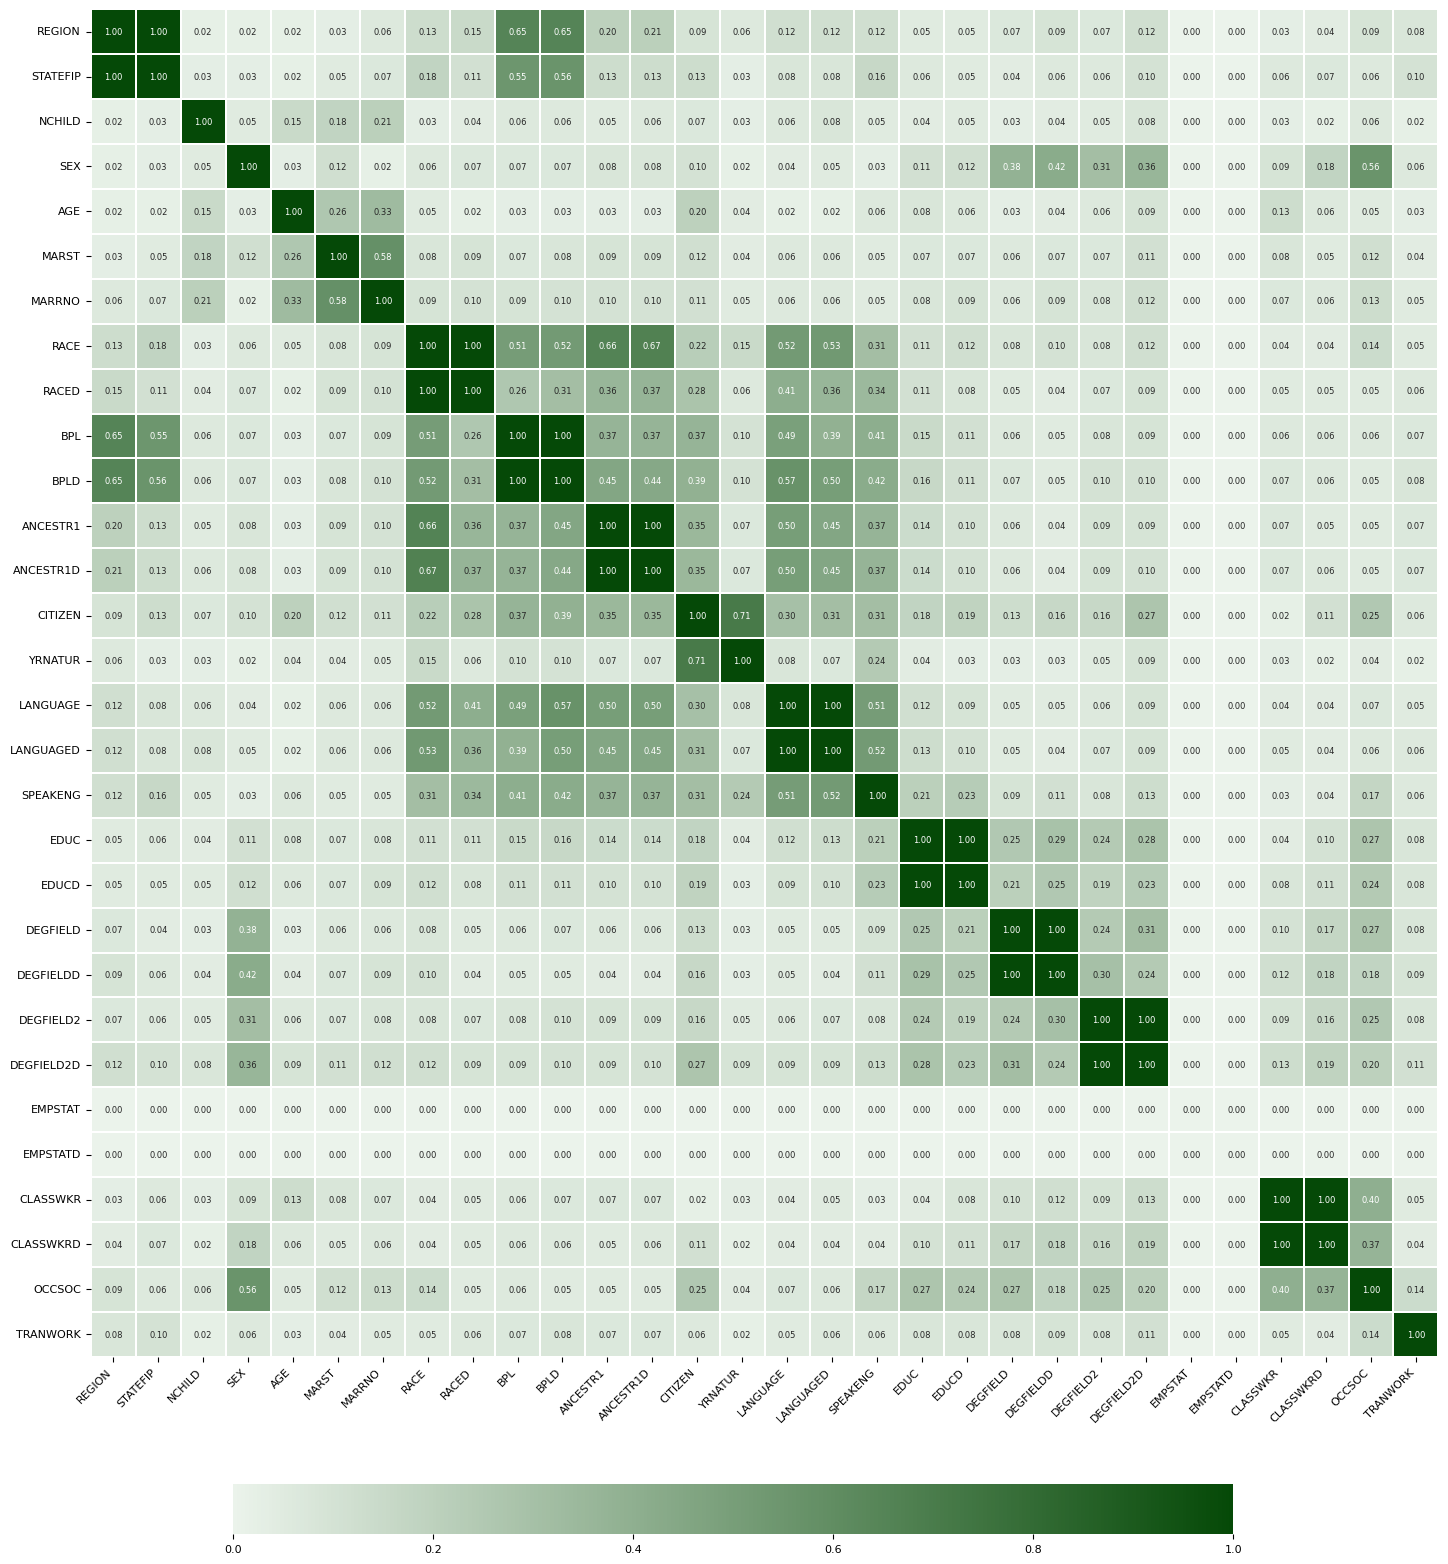

In [57]:
plt.figure(figsize=(25, 25))

axis_corr = sns.heatmap(
matrix,
vmin=0, vmax=1, center=0.5,
cmap = sns.light_palette("darkgreen", as_cmap=True, input="xkcd"),
    square=True,
    annot=True,  # Show correlation coefficients in each square
    fmt=".2f", # Format the coefficients to 2 decimal places
    annot_kws={"size": 6},  # Set font size for correlation coefficients
    linewidths=.1,  # Add lines between squares for better visibility
    cbar_kws={"shrink": .60, "orientation": "horizontal"}  # Adjust color bar (legend) size
)

# Sets the font size and rotation for the x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Adjust the position of the color legend
cbar = axis_corr.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_position([0.2, 0.27, 0.6, 0.02])

#for text in axis_corr.texts:
    #text.set_visible(True)

plt.show()

<br>

This matrix shows us that the features with "D" are perfectly correlated with the features that have the same name without 'D'. We can eliminate one of these. <br>
Degree and occupation have a strong association, unsurprisingly. Citizen and occupation have a high association. Class of the worker has high association with DEGFIELD2D. This needs more review.

In [58]:
abt.loc[:, ['EDUC','EDUCD']].head(10)

EDUC                                         EDUCD
0    1 year of college  1 or more years of college credit, no degree
1             Grade 12                   Regular high school diploma
2             Grade 12            Some college, but less than 1 year
3    1 year of college  1 or more years of college credit, no degree
4             Grade 12            Some college, but less than 1 year
5             Grade 12            Some college, but less than 1 year
6  5+ years of college                               Master's degree
7             Grade 12            Some college, but less than 1 year
8             Grade 12                   Regular high school diploma
9             Grade 12            Some college, but less than 1 year

## Pre-Processing

#### Drop Features and Rows

In [59]:
abt = abt[abt['CLASSWKRD'] != 'Unpaid family worker'].copy()

In [60]:
# features with 'D' in their name appear to be similar in content to those with the same name less the 'D' so we need only keep those without the 'D'
feature_names = abt.columns.tolist()

D_features = [f for f in feature_names if f + 'D' in feature_names]
D_features = [f + 'D' for f in D_features]

print(D_features)

['RACED', 'BPLD', 'ANCESTR1D', 'LANGUAGED', 'EDUCD', 'DEGFIELDD', 'DEGFIELD2D', 'EMPSTATD', 'CLASSWKRD']


In [61]:
abt.drop(D_features, axis = 1, inplace = True)

In [62]:
# Dropping features with cardinality of 1
abt.drop(['EMPSTAT'], axis=1, inplace =True)

In [63]:
#Dropping departs because of multicollinearity
abt.drop('DEPARTS', axis = 1, inplace = True)

In [64]:
#Dropping departs because of multicollinearity
continuous_cols.remove('DEPARTS')

In [65]:
abt.drop(['YRNATUR'], axis=1, inplace=True)

In [66]:
abt.drop(['CITIZEN'], axis=1, inplace=True)

In [67]:
abt[abt['INCWAGE'] == 0].head()

REGION STATEFIP  PERWT              NCHILD     SEX AGE                    MARST                    MARRNO                    RACE           BPL          ANCESTR1 LANGUAGE                  SPEAKENG                 EDUC                               DEGFIELD DEGFIELD2       CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  INCTOT  INCWAGE  INCINVST  INCOTHER  INCEARN             TRANWORK  TRANTIME  ARRIVES
25  East South Central Div.  Alabama   12.0     1 child present    Male  33  Married, spouse present              Married once                   White       Georgia           Italian  English  Yes, speaks only English             Grade 12                                    NaN       NaN  Self-employed  119021   770        52        50    3800        0         0         0     3800  Auto, truck, or van        20      824
50  East South Central Div.  Alabama   53.0                   3    Male  49  Married, spouse present   Married twice (or more)  Black/African American       Alabama  African-American  English  Yes, speaks only English   4 years of college              Biology and Life Sciences       NaN  Self-employed  1191XX   770        52        60   35000        0         0         0    35000  Auto, truck, or van        10      614
70  East South Central Div.  Alabama  149.0  0 children present    Male  56  Married, spouse present   Married twice (or more)                   White       Alabama            German  English  Yes, speaks only English   2 years of college                                    NaN       NaN  Self-employed  411011  5295        52        80   20000        0         0         0    20000  Auto, truck, or van        25     1029
71  East South Central Div.  Alabama  121.0  0 children present  Female  58  Married, spouse present  Married thrice (or more)                   White       Alabama            German  English  Yes, speaks only English  5+ years of college  Education Administration and Teaching       NaN  Self-employed  252030  7860        52        60   46000        0         0         0    20000  Auto, truck, or van       151     1204
75  East South Central Div.  Alabama  137.0  0 children present    Male  37  Married, spouse present              Married once                   White  Pennsylvania            German  English  Yes, speaks only English  5+ years of college  Education Administration and Teaching       NaN  Self-employed  151253  7380        52        42   60500        0      4500         0    56000       Worked at home         0        0

In [68]:
# Filter rows where INCWAGE is not equal to INCEARN and display the first few rows
abt[abt['INCWAGE'] != abt['INCEARN']].head()

REGION STATEFIP  PERWT              NCHILD     SEX AGE                    MARST                   MARRNO                    RACE      BPL          ANCESTR1 LANGUAGE                  SPEAKENG                EDUC                   DEGFIELD DEGFIELD2         CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  INCTOT  INCWAGE  INCINVST  INCOTHER  INCEARN             TRANWORK  TRANTIME  ARRIVES
25  East South Central Div.  Alabama   12.0     1 child present    Male  33  Married, spouse present             Married once                   White  Georgia           Italian  English  Yes, speaks only English            Grade 12                        NaN       NaN    Self-employed  119021   770        52        50    3800        0         0         0     3800  Auto, truck, or van        20      824
39  East South Central Div.  Alabama   65.0  0 children present  Female  28     Never married/single           Not Applicable                   White  Alabama     European, nec  English  Yes, speaks only English   1 year of college                        NaN       NaN  Works for wages  431011  7490        52        40   20600    20000         0         0    20600  Auto, truck, or van        30      904
50  East South Central Div.  Alabama   53.0                   3    Male  49  Married, spouse present  Married twice (or more)  Black/African American  Alabama  African-American  English  Yes, speaks only English  4 years of college  Biology and Life Sciences       NaN    Self-employed  1191XX   770        52        60   35000        0         0         0    35000  Auto, truck, or van        10      614
54  East South Central Div.  Alabama  114.0  0 children present    Male  64  Married, spouse present             Married once                   White  Alabama      Not Reported  English  Yes, speaks only English   1 year of college                        NaN       NaN    Self-employed  411011  4690        52        51  165400   140000     18900         0   146500  Auto, truck, or van        15      719
70  East South Central Div.  Alabama  149.0  0 children present    Male  56  Married, spouse present  Married twice (or more)                   White  Alabama            German  English  Yes, speaks only English  2 years of college                        NaN       NaN    Self-employed  411011  5295        52        80   20000        0         0         0    20000  Auto, truck, or van        25     1029

In [69]:
df[df['INCWAGE'] != df['INCEARN']].head()

REGION STATEFIP  PERWT              NCHILD     SEX AGE                    MARST                   MARRNO                    RACE                   RACED      BPL     BPLD          ANCESTR1                                ANCESTR1D CITIZEN YRNATUR LANGUAGE LANGUAGED                  SPEAKENG                EDUC                                         EDUCD                   DEGFIELD DEGFIELDD DEGFIELD2 DEGFIELD2D   EMPSTAT EMPSTATD         CLASSWKR                        CLASSWKRD  OCCSOC   IND  WKSWORK1  UHRSWORK  INCTOT  INCWAGE  INCINVST  INCOTHER  INCEARN             TRANWORK  TRANTIME  DEPARTS  ARRIVES
25  East South Central Div.  Alabama   12.0     1 child present    Male  33  Married, spouse present             Married once                   White                   White  Georgia  Georgia           Italian           Italian (1990-2000, ACS, PRCS)     NaN     nan  English   English  Yes, speaks only English            Grade 12            Some college, but less than 1 year                        NaN       NaN       NaN        NaN  Employed  At work    Self-employed  Self-employed, not incorporated  119021   770        52        50    3800        0         0         0     3800  Auto, truck, or van        20      802      824
39  East South Central Div.  Alabama   65.0  0 children present  Female  28     Never married/single           Not Applicable                   White                   White  Alabama  Alabama     European, nec                            European, nec     NaN     nan  English   English  Yes, speaks only English   1 year of college  1 or more years of college credit, no degree                        NaN       NaN       NaN        NaN  Employed  At work  Works for wages             Wage/salary, private  431011  7490        52        40   20600    20000         0         0    20600  Auto, truck, or van        30      832      904
50  East South Central Div.  Alabama   53.0                   3    Male  49  Married, spouse present  Married twice (or more)  Black/African American  Black/African American  Alabama  Alabama  African-American  African-American (1990-2000, ACS, PRCS)     NaN     nan  English   English  Yes, speaks only English  4 years of college                             Bachelor's degree  Biology and Life Sciences   Biology       NaN        NaN  Employed  At work    Self-employed  Self-employed, not incorporated  1191XX   770        52        60   35000        0         0         0    35000  Auto, truck, or van        10      602      614
54  East South Central Div.  Alabama  114.0  0 children present    Male  64  Married, spouse present             Married once                   White                   White  Alabama  Alabama      Not Reported                             Not Reported     NaN     nan  English   English  Yes, speaks only English   1 year of college  1 or more years of college credit, no degree                        NaN       NaN       NaN        NaN  Employed  At work    Self-employed  Self-employed, not incorporated  411011  4690        52        51  165400   140000     18900         0   146500  Auto, truck, or van        15      702      719
70  East South Central Div.  Alabama  149.0  0 children present    Male  56  Married, spouse present  Married twice (or more)                   White                   White  Alabama  Alabama            German             German (1990-2000, ACS/PRCS)     NaN     nan  English   English  Yes, speaks only English  2 years of college        Associate's degree, type not specified                        NaN       NaN       NaN        NaN  Employed  At work    Self-employed  Self-employed, not incorporated  411011  5295        52        80   20000        0         0         0    20000  Auto, truck, or van        25     1005     1029

In [70]:
abt[abt['INCEARN']==0]

Empty DataFrame
Columns: [REGION, STATEFIP, PERWT, NCHILD, SEX, AGE, MARST, MARRNO, RACE, BPL, ANCESTR1, LANGUAGE, SPEAKENG, EDUC, DEGFIELD, DEGFIELD2, CLASSWKR, OCCSOC, IND, WKSWORK1, UHRSWORK, INCTOT, INCWAGE, INCINVST, INCOTHER, INCEARN, TRANWORK, TRANTIME, ARRIVES]
Index: []

Wages and earned income are different in some cases. Often, when the person is self-employed 'wages' is 0. Thus, we will model on INCEARN, which has no zeros or NANs.

In [71]:
abt.drop(['INCWAGE', 'INCINVST', 'INCOTHER', 'INCTOT'], axis=1, inplace=True) # dropped all income fields except incearn; we will focus on earnings only

In [72]:
abt['AGE'] = abt['AGE'].astype(int)

In [73]:
abt['OCCSOC'] = abt['OCCSOC'].astype(str)

In [74]:
abt['INCEARN'] = abt['INCEARN'].astype(int)

In [75]:
abt['TRANTIME'] = abt['TRANTIME'].astype(int)

In [76]:
abt.drop(['ARRIVES'], axis=1, inplace =True)

In [77]:
abt.drop(['MARRNO'], axis=1, inplace =True)

In [78]:
Q1 = abt['AGE'].quantile(0.25)
Q3 = abt['AGE'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter out the rows where 'AGE' is outside the bounds
abt = abt[(abt['AGE'] >= lower_bound) & (abt['AGE'] <= upper_bound)]

In [79]:
Q1 = abt['INCEARN'].quantile(0.25)
Q3 = abt['INCEARN'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Calculate the lower and upper bounds
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Step 3: Filter out the rows where 'INCWAGE' is outside the bounds
abt = abt[(abt['INCEARN'] >= lower_bound) & (abt['INCEARN'] <= upper_bound)]

In [80]:
Q1 = abt['TRANTIME'].quantile(0.25)
Q3 = abt['TRANTIME'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Calculate the lower and upper bounds
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Step 3: Filter out the rows where 'TRANTIME' is outside the bounds
abt = abt[(abt['TRANTIME'] >= lower_bound) & (abt['TRANTIME'] <= upper_bound)]

In [81]:
print(abt.shape)

(473113, 23)


#### Imputation and Calculations

In [82]:
dqr_cat[dqr_cat['% Missing'] > 0]

Feature   Count  % Missing  Card.                                    Mode  Mode Freq.     Mode %                                2nd Mode  2nd Mode Freq.  2nd Mode %
13     CITIZEN   85008  83.077967      3                     Naturalized citizen       46195  54.341944                           Not a citizen           33234   39.095144
20    DEGFIELD  221121  55.982769     37                                Business       47582  21.518535                             Engineering           20826    9.418373
21   DEGFIELDD  221121  55.982769    172  Business Management and Administration       13593   6.147313                        General Business            9743    4.406185
22   DEGFIELD2   25203  94.982990     37                                Business        4831  19.168353                         Social Sciences            2945   11.685117
23  DEGFIELD2D   25203  94.982990    171                              Psychology        1021   4.051105  Business Management and Administration            1014    4.023331

#### Outlier Handling

Let's review the outliers before trimming them.

In [83]:
pd.set_option('display.max_colwidth', None)

In [84]:
continuous_cols, categorical_cols = define_column_types(df=abt)

In [85]:
outliers_df = pd.DataFrame(columns=['Feature', 'Outliers'])

for col in abt[continuous_cols].columns:
    outliers = []
    Q1 = abt[col].quantile(0.25)
    Q3 = abt[col].quantile(0.75)
    IQR = Q3 - Q1
    for value in abt[col].dropna():  # Ignore NaN values
        if (value < (Q1 - (1.5 * IQR))) or (value > (Q3 + (1.5 * IQR))):
            outliers.append(value)
    outliers_df = pd.concat([outliers_df, pd.DataFrame({'Feature': [col], 'Outliers': [sorted(outliers)]})], ignore_index=True)

In [86]:
outliers_df

Feature                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Outliers
0     PERWT                                                                                                      [251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, 251.0, ...]
1       AGE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           [89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89]
2       IND                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     []
3  WKSWORK1                                                                                                                                                                                                                                                                                                                                                                                                                  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50

In [87]:
# Investigate 'ARRIVES'
df.loc[df['ARRIVES'] == 0, ['TRANTIME', 'DEPARTS', 'ARRIVES']].head()

TRANTIME  DEPARTS  ARRIVES
13         0        0        0
35         0        0        0
38         0        0        0
42         0        0        0
60         0        0        0

In [88]:
# Investigate 'ARRIVES'
df.loc[df['ARRIVES'] > 2400, ['TRANTIME', 'DEPARTS', 'ARRIVES']].head()

Empty DataFrame
Columns: [TRANTIME, DEPARTS, ARRIVES]
Index: []

In [89]:
outliers_df = pd.DataFrame(columns=['Feature', 'Outliers', 'Outlier_Count'])

for col in abt[continuous_cols].columns:
    outliers = []
    Q1 = abt[col].quantile(0.25)
    Q3 = abt[col].quantile(0.75)
    IQR = Q3 - Q1
    for value in abt[col].dropna():  # Ignore NaN values
        if (value < (Q1 - (2.5 * IQR))) or (value > (Q3 + (2.5 * IQR))):
            outliers.append(value)
    outlier_count = len(outliers)
    outliers_df = pd.concat([outliers_df, pd.DataFrame({'Feature': [col], 'Outliers': [sorted(outliers)], 'Outlier_Count': [outlier_count]})], ignore_index=True)

In [90]:
outliers_df

Feature                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Outliers Outlier_Count
0     PERWT                                                                                                      [330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, 330.0, ...]         15939
1       AGE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     []             0
2       IND                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     []             0
3  WKSWORK1                                                                                                                                                                                                                                                                                                                                                                                                                  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50

Outlier Plan:
- Perwt: Consider discarding this feature due to causality concerns (see comments on scatter plot)
- Age: Drop outliers
- YRNATUR: Consider dropping this feature due to sparsity
- WKS Work: outliers are within normal bounds, i.e., 52 weeks in a year. Leave alone.
- All income fields: outliers start at a very reasonable income tier, so 1.5*IQR may be too low for such a skewed field. Suggesting we drop >2*IQR.
- TRANTIME: outliers start within a reasonable range, so we drop outliers >3*IQR.
- Arrives: Zero may mean working from home

#### Encoding

In [91]:
len(categorical_cols)

16

In [92]:
abt_encoded= abt.copy()

In [93]:
abt_encoded.head()

REGION STATEFIP  PERWT              NCHILD     SEX  AGE                 MARST                    RACE      BPL          ANCESTR1 LANGUAGE                  SPEAKENG               EDUC DEGFIELD DEGFIELD2         CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  INCEARN             TRANWORK  TRANTIME
0  East South Central Div.  Alabama   48.0  0 children present    Male   20  Never married/single  Black/African American  Georgia  African-American  English  Yes, speaks only English  1 year of college      NaN       NaN  Works for wages  399041  7870        52        40     6300  Auto, truck, or van         5
1  East South Central Div.  Alabama    9.0  0 children present  Female   52  Never married/single  Black/African American  Alabama  African-American  English  Yes, speaks only English           Grade 12      NaN       NaN  Works for wages  537051  6390        52        40    40600  Auto, truck, or van         5
2  East South Central Div.  Alabama   46.0  0 children present  Female   18  Never married/single  Black/African American  Alabama  African-American  English  Yes, speaks only English           Grade 12      NaN       NaN  Works for wages  412010  5391        52        41     6000  Auto, truck, or van        25
3  East South Central Div.  Alabama   54.0  0 children present    Male   20  Never married/single  Black/African American  Georgia  African-American  English  Yes, speaks only English  1 year of college      NaN       NaN  Works for wages  399041  7870        52        40     6300  Auto, truck, or van         5
4  East South Central Div.  Alabama   42.0  0 children present  Female   18  Never married/single  Black/African American  Florida  African-American  English  Yes, speaks only English           Grade 12      NaN       NaN  Works for wages  352010  8680        52        35    26400          Walked only         3

#### 

In [94]:
# Generate a report of unique values for each categorical column
categorical_unique_values = {}

for col in categorical_cols:
    if col in abt_encoded.columns:  # Check if the column exists in the DataFrame
        unique_values = abt_encoded[col].unique()
        categorical_unique_values[col] = unique_values
    else:
        print(f"Warning: Column '{col}' does not exist in the DataFrame.")

# Display the report
for col, unique_values in categorical_unique_values.items():
    print(f"Column: {col}")
    print(f"Unique Values ({len(unique_values)}): {unique_values}")
    print("-" * 50)

Column: REGION
Unique Values (9): ['East South Central Div.' 'Pacific Division' 'Mountain Division'
 'West South Central Div.' 'New England Division'
 'South Atlantic Division' 'East North Central Div.'
 'West North Central Div.' 'Middle Atlantic Division']
--------------------------------------------------
Column: STATEFIP
Unique Values (51): ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']
-------------------------------------------------

In [95]:
# Identify categorical columns with only 2 unique values
binary_categorical_cols = [col for col in categorical_cols if col in abt_encoded.columns and abt_encoded[col].nunique() == 2]
print(binary_categorical_cols)

['SEX', 'CLASSWKR']


In [96]:
# Perform one-hot encoding for binary categorical columns
for col in binary_categorical_cols:
    if col in abt_encoded.columns:
        abt_encoded[col] = pd.get_dummies(abt_encoded[col], drop_first=True)

In [97]:
print(categorical_cols)

['REGION', 'STATEFIP', 'NCHILD', 'SEX', 'MARST', 'RACE', 'BPL', 'ANCESTR1', 'LANGUAGE', 'SPEAKENG', 'EDUC', 'DEGFIELD', 'DEGFIELD2', 'CLASSWKR', 'OCCSOC', 'TRANWORK']


In [98]:
abt_encoded['NCHILD'] = abt_encoded['NCHILD'].replace({
    "0 children present": 0,
    "1 child present": 1,
    "9+": 9
})
abt_encoded['NCHILD']

0         0
1         0
2         0
3         0
4         0
         ..
502358    2
502359    0
502360    0
502361    4
502362    0
Name: NCHILD, Length: 473113, dtype: object

In [99]:
abt_encoded.head(1)

REGION STATEFIP  PERWT NCHILD   SEX  AGE                 MARST                    RACE      BPL          ANCESTR1 LANGUAGE                  SPEAKENG               EDUC DEGFIELD DEGFIELD2  CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  INCEARN             TRANWORK  TRANTIME
0  East South Central Div.  Alabama   48.0      0  True   20  Never married/single  Black/African American  Georgia  African-American  English  Yes, speaks only English  1 year of college      NaN       NaN      True  399041  7870        52        40     6300  Auto, truck, or van         5

In [100]:
from sklearn.preprocessing import LabelEncoder

# Perform label encoding for the specified categorical columns
columns_to_encode = ['REGION', 'STATEFIP', 'MARST', 'MARRNO', 'RACE', 'BPL', 'ANCESTR1', 'LANGUAGE', 'TRANWORK']
label_encoders = {}

for col in columns_to_encode:
    if col in abt_encoded.columns:
        le = LabelEncoder()
        abt_encoded[col] = le.fit_transform(abt_encoded[col])
        label_encoders[col] = le  # Store the encoder for future use if needed

In [101]:
degfield_unique_values = abt_encoded['DEGFIELD'].unique()
degfield2_unique_values = abt_encoded['DEGFIELD2'].unique()

print("Unique values in DEGFIELD:")
print(degfield_unique_values)

print("\nUnique values in DEGFIELD2:")
print(degfield2_unique_values)

Unique values in DEGFIELD:
[nan 'Theology and Religious Vocations'
 'Linguistics and Foreign Languages'
 'Public Affairs, Policy, and Social Work' 'Engineering'
 'Computer and Information Sciences' 'Mathematics and Statistics'
 'Environment and Natural Resources' 'Business' 'Psychology'
 'Biology and Life Sciences' 'Education Administration and Teaching'
 'Physical Sciences' 'Medical and Health Sciences and Services'
 'Social Sciences' 'Engineering Technologies'
 'Criminal Justice and Fire Protection' 'Family and Consumer Sciences'
 'Liberal Arts and Humanities'
 'English Language, Literature, and Composition'
 'Area, Ethnic, and Civilization Studies'
 'Interdisciplinary and Multi-Disciplinary Studies (General)'
 'Physical Fitness, Parks, Recreation, and Leisure' 'Communications'
 'Fine Arts' 'History' 'Construction Services'
 'Transportation Sciences and Technologies' 'Agriculture'
 'Philosophy and Religious Studies' 'Architecture'
 'Communication Technologies' 'Cosmetology Services a

In [102]:
manual_degree_order = [
    'Engineering',
    'Computer and Information Sciences',
    'Mathematics and Statistics',
    'Business',
    'Law',
    'Architecture',
    'Physical Sciences',
    'Medical and Health Sciences and Services',
    'Biology and Life Sciences',
    'Environment and Natural Resources',
    'Social Sciences',
    'Public Affairs, Policy, and Social Work',
    'Psychology',
    'Education Administration and Teaching',
    'Communications',
    'Linguistics and Foreign Languages',
    'English Language, Literature, and Composition',
    'History',
    'Area, Ethnic, and Civilization Studies',
    'Interdisciplinary and Multi-Disciplinary Studies (General)',
    'Fine Arts',
    'Physical Fitness, Parks, Recreation, and Leisure',
    'Family and Consumer Sciences',
    'Agriculture',
    'Philosophy and Religious Studies',
    'Theology and Religious Vocations',
    'Library Science',
    'Criminal Justice and Fire Protection',
    'Engineering Technologies',
    'Construction Services',
    'Transportation Sciences and Technologies',
    'Electrical and Mechanic Repairs and Technologies',
    'Nuclear, Industrial Radiology, and Biological Technologies',
    'Communication Technologies',
    'Cosmetology Services and Culinary Arts',
    'Military Technologies',
]


In [103]:
# Create mapping: top degree gets 0, next gets 1, etc.
degree_to_manual_label = {degree: idx for idx, degree in enumerate(manual_degree_order)}

# Apply it
abt_encoded['DEGFIELD_ENCODED'] = abt_encoded['DEGFIELD'].map(degree_to_manual_label).fillna(-1).astype(int)
abt_encoded['DEGFIELD2_ENCODED'] = abt_encoded['DEGFIELD2'].map(degree_to_manual_label).fillna(-1).astype(int)

# drop the original columns
abt_encoded.drop(['DEGFIELD', 'DEGFIELD2'], axis=1, inplace=True)


In [106]:
'''
Citizen_Unique_Values = abt_encoded['CITIZEN'].unique()

print("Unique values in CITIZEN:")
print(Citizen_Unique_Values)

# Your manual order
manual_citizenship_order = [
    "Born abroad of American parents",
    "Naturalized citizen",
    "Not a citizen"
]

# Create mapping: first in list gets 1, second gets 2, etc. (start from 1 because NaN will be 0)
citizenship_to_label = {value: idx + 1 for idx, value in enumerate(manual_citizenship_order)}

# Map the column
abt_encoded['CITIZEN_ENCODED'] = abt_encoded['CITIZEN'].map(citizenship_to_label)

# Fill NaNs with 0 (best value)
abt_encoded['CITIZEN_ENCODED'] = abt_encoded['CITIZEN_ENCODED'].fillna(0).astype(int)

abt_encoded.drop(['CITIZEN'], axis=1, inplace=True)'''

'\nCitizen_Unique_Values = abt_encoded[\'CITIZEN\'].unique()\n\nprint("Unique values in CITIZEN:")\nprint(Citizen_Unique_Values)\n\n# Your manual order\nmanual_citizenship_order = [\n    "Born abroad of American parents",\n    "Naturalized citizen",\n    "Not a citizen"\n]\n\n# Create mapping: first in list gets 1, second gets 2, etc. (start from 1 because NaN will be 0)\ncitizenship_to_label = {value: idx + 1 for idx, value in enumerate(manual_citizenship_order)}\n\n# Map the column\nabt_encoded[\'CITIZEN_ENCODED\'] = abt_encoded[\'CITIZEN\'].map(citizenship_to_label)\n\n# Fill NaNs with 0 (best value)\nabt_encoded[\'CITIZEN_ENCODED\'] = abt_encoded[\'CITIZEN_ENCODED\'].fillna(0).astype(int)\n\nabt_encoded.drop([\'CITIZEN\'], axis=1, inplace=True)'

In [107]:
Speaking_Unique_Values = abt_encoded['SPEAKENG'].unique()

print("Unique values in SPEAKENG:")
print(Speaking_Unique_Values)

Unique values in SPEAKENG:
['Yes, speaks only English' 'Yes, speaks well' 'Yes, but not well'
 'Yes, speaks very well' 'Does not speak English']


In [108]:
# Manual order from best to worst
manual_speakeng_order = [
    'Yes, speaks only English',
    'Yes, speaks very well',
    'Yes, speaks well',
    'Yes, but not well',
    'Does not speak English'
]

# Create mapping: first = 0 (best), second = 1, etc.
speakeng_to_label = {value: idx for idx, value in enumerate(manual_speakeng_order)}

# Map it
abt_encoded['SPEAKENG_ENCODED'] = abt_encoded['SPEAKENG'].map(speakeng_to_label)

abt_encoded.drop(["SPEAKENG"], axis=1, inplace=True)


In [109]:
EDUC_Unique_Values = abt_encoded['EDUC'].unique()

print("Unique values in EDUC:")
print(EDUC_Unique_Values)

Unique values in EDUC:
['1 year of college' 'Grade 12' '5+ years of college' 'Grade 10'
 '2 years of college' '4 years of college' 'Grade 5, 6, 7, or 8'
 'Grade 11' 'N/A or no schooling' 'Grade 9' 'Nursery school to grade 4']


In [110]:
manual_educ_order = [
    '5+ years of college',           # Highest (grad school / master's+)
    '4 years of college',             # Bachelor's
    '2 years of college',             # Associate's degree
    '1 year of college',              # Some college
    'Grade 12',                       # High school graduate
    'Grade 11',
    'Grade 10',
    'Grade 9',
    'Grade 5, 6, 7, or 8',
    'Nursery school to grade 4',
    'N/A or no schooling'             # No formal schooling (worst)
]
# Create mapping: best education = 0, worse ones get higher numbers
educ_to_label = {value: idx for idx, value in enumerate(manual_educ_order)}

# Apply mapping
abt_encoded['EDUC_ENCODED'] = abt_encoded['EDUC'].map(educ_to_label)

abt_encoded.drop(["EDUC"], axis=1, inplace=True)


In [111]:
abt_encoded.head(1)

REGION  STATEFIP  PERWT NCHILD   SEX  AGE  MARST  RACE  BPL  ANCESTR1  LANGUAGE  CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  INCEARN  TRANWORK  TRANTIME  DEGFIELD_ENCODED  DEGFIELD2_ENCODED  SPEAKENG_ENCODED  EDUC_ENCODED
0       1         0   48.0      0  True   20      3     1   32         3        15      True  399041  7870        52        40     6300         0         5                -1                 -1                 0             3

# Function to convert string to float. We use this to clean topcoded features.
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        # Handle the specific case of '99 (Topcode)'
        if value == '99 (Topcode)':
            return 99.0
        else:
            raise

# Apply the conversion function to your data
abt_encoded = abt_encoded.applymap(convert_to_float)

In [119]:
abt_encoded.head()

REGION  STATEFIP  PERWT NCHILD    SEX  AGE  MARST  RACE  BPL  ANCESTR1  LANGUAGE  CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  INCEARN  TRANWORK  TRANTIME  DEGFIELD_ENCODED  DEGFIELD2_ENCODED  SPEAKENG_ENCODED  EDUC_ENCODED
0       1         0   48.0      0   True   20      3     1   32         3        15      True  399041  7870        52        40     6300         0         5                -1                 -1                 0             3
1       1         0    9.0      0  False   52      3     1    2         3        15      True  537051  6390        52        40    40600         0         5                -1                 -1                 0             4
2       1         0   46.0      0  False   18      3     1    2         3        15      True  412010  5391        52        41     6000         0        25                -1                 -1                 0             4
3       1         0   54.0      0   True   20      3     1   32         3        15      True  399041  7870        52        40     6300         0         5                -1                 -1                 0             3
4       1         0   42.0      0  False   18      3     1   30         3        15      True  352010  8680        52        35    26400        10         3                -1                 -1                 0             4

In [120]:
# Drop the old columns, keeping only the encoded columns
abt_encoded_prepped = abt_encoded.copy()

In [121]:
abt_encoded_prepped.head()

REGION  STATEFIP  PERWT NCHILD    SEX  AGE  MARST  RACE  BPL  ANCESTR1  LANGUAGE  CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  INCEARN  TRANWORK  TRANTIME  DEGFIELD_ENCODED  DEGFIELD2_ENCODED  SPEAKENG_ENCODED  EDUC_ENCODED
0       1         0   48.0      0   True   20      3     1   32         3        15      True  399041  7870        52        40     6300         0         5                -1                 -1                 0             3
1       1         0    9.0      0  False   52      3     1    2         3        15      True  537051  6390        52        40    40600         0         5                -1                 -1                 0             4
2       1         0   46.0      0  False   18      3     1    2         3        15      True  412010  5391        52        41     6000         0        25                -1                 -1                 0             4
3       1         0   54.0      0   True   20      3     1   32         3        15      True  399041  7870        52        40     6300         0         5                -1                 -1                 0             3
4       1         0   42.0      0  False   18      3     1   30         3        15      True  352010  8680        52        35    26400        10         3                -1                 -1                 0             4

#### Encoding for Occupation and Industry using target encoding (Leave One Out) in model step up after train test split

## Step 2: Modeling

### Model Setup

In this section, we prepare for modeling by setting a random seed (for consistency) and split the data into training and testing sets.

In [122]:
np.random.seed(777) 
#By setting a random seed, we can leave comments about performance that will still be accurate when the code is reviewed.
#This can be commented out to restore a truly random output, but note that all comments on performance were made with random seed set to 890.

In [123]:
abt_prepped=abt_encoded_prepped.copy()

In [124]:
X = abt_prepped.drop('INCEARN', axis=1)
y = abt_prepped['INCEARN']

In [125]:
# For datasets with a pre-defined test flag only: 
# Split the abt into two sets, one for training and one for validation.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [126]:
# For datasets without a preset split, i.e., no flag:

In [127]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=777)

In [128]:
x_train.head()

REGION  STATEFIP  PERWT NCHILD    SEX  AGE  MARST  RACE  BPL  ANCESTR1  LANGUAGE  CLASSWKR  OCCSOC   IND  WKSWORK1  UHRSWORK  TRANWORK  TRANTIME  DEGFIELD_ENCODED  DEGFIELD2_ENCODED  SPEAKENG_ENCODED  EDUC_ENCODED
71059        5         4   73.0      2  False   42      2     3   15        98        15      True  131022  4390        52        40        11         0                 3                 22                 0             1
39697        5         4   53.0      0  False   56      0     8   15       192        15      True  119030  7870        52        55        11         0                17                 -1                 0             0
267228       3        26  303.0      3   True   34      2     8  120       192        15      True  339030  9480        52        40         0        75                -1                 -1                 0             3
463130       6        46   60.0      1   True   61      2     8    0       122        39      True  352010  8680        51        35         0        20                -1                 -1                 2             4
66139        5         4   67.0      1  False   58      5     7   65       115        54      True  5191XX  5690        52        40         0        45                -1                 -1                 4            10

In [136]:
feature_cols = ['OCCSOC', 'IND']


# 2. Set up LeaveOneOutEncoder
loo_encoder = ce.LeaveOneOutEncoder(
    cols=feature_cols,
    sigma=0.1
)

# 3. Fit the encoder **only** on training data
loo_encoder.fit(x_train, y_train)

# 4. Transform both training and test set
x_train = loo_encoder.transform(x_train)
x_test = loo_encoder.transform(x_test)

In [137]:
x_train.head()

REGION  STATEFIP  PERWT NCHILD    SEX  AGE  MARST  RACE  BPL  ANCESTR1  LANGUAGE  CLASSWKR        OCCSOC           IND  WKSWORK1  UHRSWORK  TRANWORK  TRANTIME  DEGFIELD_ENCODED  DEGFIELD2_ENCODED  SPEAKENG_ENCODED  EDUC_ENCODED
71059        5         4   73.0      2  False   42      2     3   15        98        15      True  53357.094595  66732.280702        52        40        11         0                 3                 22                 0             1
39697        5         4   53.0      0  False   56      0     8   15       192        15      True  80713.023187  69092.077572        52        55        11         0                17                 -1                 0             0
267228       3        26  303.0      3   True   34      2     8  120       192        15      True  44097.276575  66129.104389        52        40         0        75                -1                 -1                 0             3
463130       6        46   60.0      1   True   61      2     8    0       122        39      True  26798.732735  36878.616297        51        35         0        20                -1                 -1                 2             4
66139        5         4   67.0      1  False   58      5     7   65       115        54      True  44280.470654  53318.670968        52        40         0        45                -1                 -1                 4            10

In [129]:
#x_train.dtypes

#### Performance Check

Here, we set up a function to display all of the important performance metics. This function can be called after training each model variant.

In [138]:
# Creating a function for reporting performance parameters

def perf(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    perf_results = pd.DataFrame({'MSE': [mse], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape], 'R-squared': [r2]})

    return display(perf_results.style.hide(axis="index")) #displays a dataframe of all the performance metrics

<br>

### Gradient Boost

Now let's start with a basic Gradient Boost model.

In [139]:
# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=450, learning_rate=0.2, max_depth=9, random_state=777, loss='absolute_error')

# Train the model
gbr.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, loss='absolute_error', max_depth=9,
                          n_estimators=450, random_state=777)

In [140]:
# Make predictions
y_pred = gbr.predict(x_test)

In [142]:
# Evaluate the model
perf(y_test, y_pred) # output performance metrics

In [143]:
predictions_df = {
    'actual': y_test,
    'predicted': y_pred
}

In [144]:
# Calculate error
predictions_df['error'] = (predictions_df['actual'] - predictions_df['predicted'])

In [145]:
#Calculate mean absolute error
predictions_df['absolute_percentage_error'] = abs(predictions_df['error'] / predictions_df['actual']) * 100

In [146]:
predictions_df = pd.DataFrame(predictions_df)

In [147]:
# Filter rows where absolute percentage error is greater than 70%
highest_error_df = predictions_df[predictions_df['absolute_percentage_error'] > 70]

In [148]:
highest_error_df.to_csv('obs_with_highest_error')

In [149]:
len(highest_error_df)

11044

In [150]:
highest_error_df.head(20)

actual      predicted         error  absolute_percentage_error
434778   20000   38081.579871 -18081.579871                  90.407899
173262   65000  118525.674738 -53525.674738                  82.347192
422185   35000   60746.782988 -25746.782988                  73.562237
221751   37000   77693.508170 -40693.508170                 109.982455
266106    7000   36386.474627 -29386.474627                 419.806780
172765    8400   29101.774366 -20701.774366                 246.449695
144507   15000   34735.929639 -19735.929639                 131.572864
402578   25000   46926.938765 -21926.938765                  87.707755
85661    14800   88438.151598 -73638.151598                 497.555078
371260    7500   29439.016000 -21939.016000                 292.520213
377422    8200   39577.562488 -31377.562488                 382.653201
447267   52000  123594.972543 -71594.972543                 137.682640
446093   14000   30365.935035 -16365.935035                 116.899536
240088   46000   92037.063644 -46037.063644                 100.080573
173866   20000   34185.460623 -14185.460623                  70.927303
240066   18500   41895.683504 -23395.683504                 126.463154
28547    10000   30476.930834 -20476.930834                 204.769308
68734     7000   24043.584215 -17043.584215                 243.479774
15763    26400   89070.860236 -62670.860236                 237.389622
415406   14400   26136.372745 -11736.372745                  81.502589

This shows us where the greatest error is. From here, we can see if there is a pattern in the data contributing the most to the error.

#### Tuning

Next, let's tune using n-estimators...

##### N_Estimators

Next, let's test different values of n_estimators to find the optimal value for this hyperparameter. N_estimators represents the number of decision trees used to generate the predictions. 

In [151]:
n_estimator_lst = range(50, 550,50) # defines a list of values to try for n_estimators

Visualize the change in n_estimators

In [ ]:
# generates a line graph of the training MAPE and testing MAPE for comparison

# List to store MAPE values
mape_train = []
mape_test = []

# Train and evaluate the model for each hyperparameter value
for n_estimators in n_estimator_lst:
    model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=777, loss='absolute_error')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mape_values_test = mean_absolute_percentage_error(y_test, y_pred)
    mape_test.append(mape_values_test)
    mape_values_train = mean_absolute_percentage_error(y_train, model.predict(x_train))
    mape_train.append(mape_values_train)


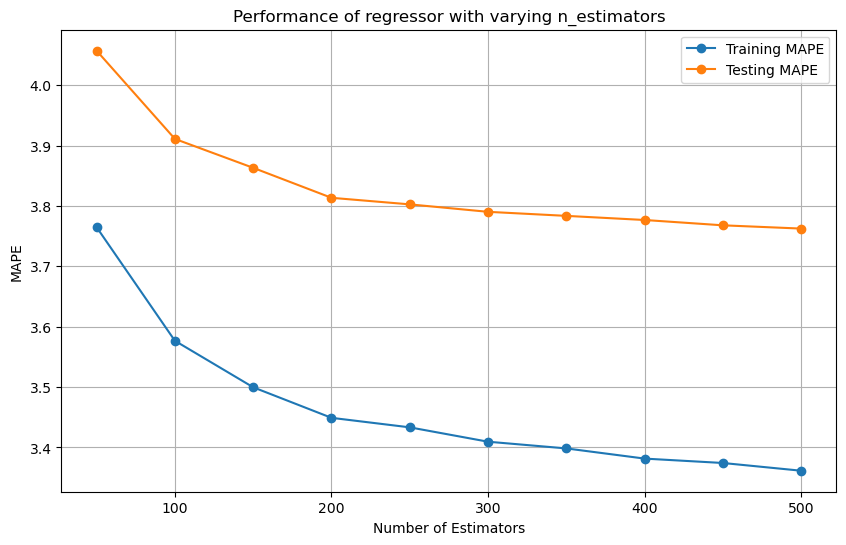

In [ ]:
# generates a line graph of the training MAPE and testing MAPE for comparison
plt.figure(figsize=(10, 6))
plt.plot(n_estimator_lst, mape_train, marker='o', label='Training MAPE')
plt.plot(n_estimator_lst, mape_test, marker='o', label='Testing MAPE')
plt.title('Performance of regressor with varying n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# display the results as a dataframe
n_est_results = pd.DataFrame({'Estimators': n_estimator_lst, 'MAPE': mape_test})
n_est_results.reset_index(drop=True, inplace=True)
display(n_est_results[3:10].style.hide(axis="index"))

Comment on outcome __TBD__

In [ ]:
perf(y_test, y_pred)

In [ ]:
#store_metrics('Gradient Boost') # saving these metrics for comparison across models

Hyperparameter Tuning

##### Max_depth

First, we'll try varying maximum depth to better understand hyperparameter tuning.

In [ ]:
max_depths = range(1, 20) # defines a list of values to try for max_depth

In [ ]:
# generates a line graph of the training MAPE and testing MAPE for comparison

# List to store MAPE values
mape_train = []
mape_test = []

# Train and evaluate the model for each hyperparameter value
for depth in max_depths:
    model = GradientBoostingRegressor(max_depth=depth, random_state=777, loss='absolute_error')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mape_values_test = mean_absolute_percentage_error(y_test, y_pred)
    mape_test.append(mape_values_test)
    mape_values_train = mean_absolute_percentage_error(y_train, model.predict(x_train))
    mape_train.append(mape_values_train)

Visualize the change in max_depth

<Figure size 1000x600 with 0 Axes>

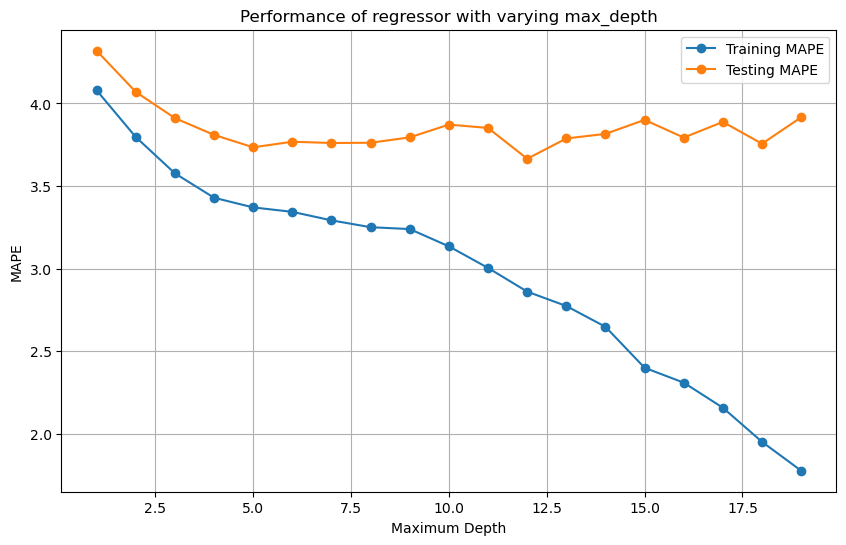

In [ ]:
# generates a line graph of the training MAPE and testing MAPE for comparison
plt.figure(figsize=(10, 6))
plt.plot(max_depths, mape_train, marker='o', label='Training MAPE')
plt.plot(max_depths, mape_test, marker='o', label='Testing MAPE')
plt.title('Performance of regressor with varying max_depth')
plt.xlabel('Maximum Depth')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# outputs a table of the AUC results
max_depth_mape_results = pd.DataFrame({'max_depth': max_depths, 'MAPE': mape_test})
max_depth_mape_results.reset_index(drop=True, inplace=True)
display(max_depth_mape_results[5:15].style.hide(axis="index"))

Comment on hyperparameters: TBD

### K-Fold Cross Validation

In this section, we use k-fold cross validation can be used in tandem with GridSearchCV to find the optimal hyperparameter values for multiple hyperparameters simultantously.

In [ ]:
# Note that K-fold cross validation is processor-intensive. It may take some time to run. 
# This section can be skipped.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
model = GradientBoostingRegressor(random_state=777)

# Use KFold for regression problems
kfold = KFold(n_splits=5, shuffle=True, random_state=777)

# Set up GridSearchCV
gs = GridSearchCV(model,
                  param_grid={'max_depth': range(7, 20),
                              'n_estimators': range(200, 600, 50)},
                  cv=kfold,
                  n_jobs=-1,
                  scoring='neg_mean_absolute_percentage_error')

# Fit the model
gs.fit(x_train, y_train)

# Print the best parameters and best score
print(gs.best_params_)
print(gs.best_score_)

NameError: name 'X_train' is not defined

Based on the cross-validation results, the best hyperparameters to use are max_depth = 9 and n_estimators = 450.

#### Tuned Model

Here, we re-run the model using the optimal hyperparameters.

In [ ]:
# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=450, learning_rate=0.2, max_depth=9, random_state=777, loss='absolute_error')

# Train the model
gbr.fit(x_train, y_train)

# Make predictions
y_pred = gbr.predict(x_test)

# Evaluate the model
perf(y_test, y_pred) # output performance metrics

In [ ]:
# Re-run the model using the optimal n_estimators value
gb = GradientBoostingClassifier(n_estimators=100,random_state=890)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)

<br>

#### Simulation

Here, we simulate outcomes for males vs. females for comparison.

In [ ]:
x_test_m = X_test.copy()
x_test_m['SEX_Female'] = 0.0
x_test_m['SEX_Male'] = 1.0

In [ ]:
#x_test_m.columns.tolist()

In [ ]:
x_test_f = X_test.copy()
x_test_f['SEX_Female'] = 1.0
x_test_f['SEX_Male'] = 0.0

In [ ]:
y_pred_m = gbr.predict(x_test_m)

In [ ]:
y_pred_f = gbr.predict(x_test_f)

In [ ]:
y_pred_m.mean()

62808.490678134054

In [ ]:
perf(y_test, y_pred) # output performance metrics

In [ ]:
y_pred_f.mean()

55264.425799437304

<br>

In [ ]:
metrics_df = pd.DataFrame(columns=['Metric'])

def store_metrics(model_name):
    global metrics_df
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Create a dictionary of metrics
    metrics = {
        'Accuracy': acc,
        'AUC': roc_auc
    }
    
    # Add metrics to the DataFrame
    for metric, value in metrics.items():
        if metric not in metrics_df['Metric'].values:
            new_row = pd.DataFrame({'Metric': [metric]})
            metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
        metrics_df.loc[metrics_df['Metric'] == metric, model_name] = value

#    return metrics_df


In [ ]:
store_metrics('Gradient Boost') # saving these metrics for comparison across models

### AdaBoost Model

First, we start with a basic AdaBoost Model.

In [ ]:
ada = AdaBoostClassifier(random_state=890) # Defining the model type, and setting a random_state for consistency. All other hyperparameters are default.
ada.fit(x_train, y_train) # training the model using the training data
y_pred = ada.predict(x_test) # predict results based on the test data

In [ ]:
perf(y_test, y_pred) # call custom function to report on performance

Now that we have a baseline, showing the performance using the defaults, we will vary n_estimators and see if a different number of decision trees can perform better.

In [ ]:
n_estimator_lst = range(50, 550,50) # defines a list of values to try for n_estimators
train_auc = []
test_auc = []
train_accuracy = []
test_accuracy = []

for n_estimators in n_estimator_lst:
    # train with hyperparameter
    ada = AdaBoostClassifier(n_estimators=n_estimators, random_state=890)
    ada.fit(x_train, y_train)

    #Predict results for training set and log metics AUC and accuracy
    train_y_pred = ada.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_acc = np.mean(y_train==train_y_pred)
    train_auc.append(roc_auc)
    train_accuracy.append(train_acc)

    #Predict results for test set and log metics AUC and accuracy
    y_pred = ada.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_acc = np.mean(y_test==y_pred)
    test_auc.append(roc_auc)
    test_accuracy.append(test_acc)

Visualize the change in n_estimators

In [ ]:
# generates a line graph of the training AUC and testing AUC for comparison
line1, = plt.plot(n_estimator_lst, train_auc, 'b', label="Train AUC")
line2, = plt.plot(n_estimator_lst, test_auc, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
# generates a line graph of the training accuracy and testing accuracy for comparison
line1, = plt.plot(n_estimator_lst, train_accuracy, 'b', label="Train Accuracy")
line2, = plt.plot(n_estimator_lst, test_accuracy, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

Optimal n_estimators is 50. In both graphs, there is a steep decline between 50 and 100 estimators, suggesting an increase in estimators degrades predictive ability.

In [ ]:
ada = AdaBoostClassifier(n_estimators=50,random_state=890)
ada.fit(x_train, y_train)
y_pred = ada.predict(x_test)

In [ ]:
perf(y_test, y_pred)

In [ ]:
store_metrics('Ada Boost') # saving these metrics for comparison across models

### Extreme Gradient Boosting (XGB)

Here, we start with a basic XGB model.

In [ ]:
xgb = XGBRegressor(random_state=777) # define model
xgb.fit(x_train, y_train) #train
y_pred = xgb.predict(x_test) # predict

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670], got [     0      4     10     20     30     50     60     70    100    120
    130    150    160    180    190    200    210    240    250    270
    290    300    350    360    400    480    500    520    550    560
    600    650    680    700    750    800    850    900    950   1000
   1100   1200   1300   1400   1500   1600   1700   1800   1900   2000
   2100   2300   2400   2500   2600   2700   2800   2900   3000   3100
   3200   3300   3400   3500   3600   3700   3800   3900   4000   4100
   4200   4300   4400   4500   4600   4700   4800   4900   5000   5100
   5200   5300   5400   5500   5600   5700   5800   5900   6000   6100
   6200   6300   6400   6500   6600   6700   6800   6900   7000   7100
   7200   7300   7400   7500   7600   7700   7800   7900   8000   8100
   8200   8300   8400   8500   8600   8700   8800   8900   9000   9100
   9200   9300   9400   9500   9600   9700   9800   9900  10000  10100
  10200  10300  10400  10500  10600  10700  10800  10900  11000  11100
  11200  11300  11400  11500  11600  11700  11800  11900  12000  12100
  12200  12300  12400  12500  12600  12700  12800  12900  13000  13100
  13200  13300  13400  13500  13600  13700  13800  13900  14000  14100
  14200  14300  14400  14500  14600  14700  14800  14900  15000  15100
  15200  15300  15400  15500  15600  15700  15800  15900  16000  16100
  16200  16300  16400  16500  16600  16700  16800  16900  17000  17100
  17200  17300  17400  17500  17600  17700  17800  17900  18000  18100
  18200  18300  18400  18500  18600  18700  18800  18900  19000  19100
  19200  19300  19400  19500  19600  19700  19800  19900  20000  20100
  20200  20300  20400  20500  20600  20700  20800  20900  21000  21100
  21200  21300  21400  21500  21600  21700  21800  21900  22000  22100
  22200  22300  22400  22500  22600  22700  22800  22900  23000  23100
  23200  23300  23400  23500  23600  23700  23800  23900  24000  24100
  24200  24300  24400  24500  24600  24700  24800  24900  25000  25100
  25200  25300  25400  25500  25600  25700  25800  25900  26000  26100
  26200  26300  26400  26500  26600  26700  26800  26900  27000  27100
  27200  27300  27400  27500  27600  27700  27800  27900  28000  28100
  28200  28300  28400  28500  28600  28700  28800  28900  29000  29100
  29200  29300  29400  29500  29600  29700  29800  29900  30000  30100
  30200  30300  30400  30500  30600  30700  30800  30900  31000  31100
  31200  31300  31400  31500  31600  31700  31800  31900  32000  32100
  32200  32300  32400  32500  32600  32700  32800  32900  33000  33100
  33200  33300  33400  33500  33600  33700  33800  33900  34000  34100
  34200  34300  34400  34500  34600  34700  34800  34900  35000  35100
  35200  35300  35400  35500  35600  35700  35800  35900  36000  36100
  36200  36300  36400  36500  36600  36700  36800  36900  37000  37100
  37200  37300  37400  37500  37600  37700  37800  37900  38000  38100
  38200  38300  38400  38500  38600  38700  38800  38900  39000  39100
  39200  39300  39400  39500  39600  39700  39800  39900  40000  40100
  40200  40300  40400  40500  40600  40700  40800  40900  41000  41100
  41200  41300  41400  41500  41600  41700  41800  41900  42000  42100
  42200  42300  42400  42500  42600  42700  42800  42900  43000  43100
  43200  43300  43400  43500  43600  43700  43800  43900  44000  44100
  44200  44300  44400  44500  44600  44700  44800  44900  45000  45100
  45200  45300  45400  45500  45600  45700  45800  45900  46000  46100
  46200  46300  46400  46500  46600  46700  46800  46900  47000  47100
  47200  47300  47400  47500  47600  47700  47800  47900  48000  48100
  48200  48300  48400  48500  48600  48700  48800  48900  49000  49100
  49200  49300  49400  49500  49600  49700  49800  49900  50000  51000
  52000  53000  54000  55000  56000  57000  58000  59000  60000  61000
  62000  63000  64000  65000  66000  67000  68000  69000  70000  71000
  72000  73000  74000  75000  76000  77000  78000  79000  80000  81000
  82000  83000  84000  85000  86000  87000  88000  89000  90000  91000
  92000  93000  94000  95000  96000  97000  98000  99000 100000 101000
 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000
 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000
 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000
 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000
 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000
 152000 153000 154000 155000 156000 157000 158000 159000 160000 161000
 162000 163000 164000 165000 166000 167000 168000 169000 170000 171000
 172000 173000 174000 175000 176000 177000 178000 179000 180000 181000
 182000 183000 184000 185000 186000 187000 188000 189000 190000 191000
 192000]

In [ ]:
perf(y_test, y_pred) # output metrics

Now we tune using n_estimators.

In [ ]:
n_estimator_lst = range(50, 550, 50) # creates a list of values we will try for n_estimators
train_auc = []
test_auc = []
train_accuracy = []
test_accuracy = []

# loops through the different hyperparameter values and stores the performance
for n_estimators in n_estimator_lst:
    # train with hyperparameter
    xgb = XGBClassifier(n_estimators=n_estimators, random_state=890)
    xgb.fit(x_train, y_train)

    #Predict results for training set and log metics AUC and accuracy
    train_y_pred = xgb.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_acc = np.mean(y_train==train_y_pred)
    train_auc.append(roc_auc)
    train_accuracy.append(train_acc)

    #Predict results for test set and log metics AUC and accuracy
    y_pred = xgb.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_acc = np.mean(y_test==y_pred)
    test_auc.append(roc_auc)
    test_accuracy.append(test_acc)

Visualize the change in n_estimators

In [ ]:
# generates a line graph of the training AUC and testing AUC for comparison
line1, = plt.plot(n_estimator_lst, train_auc, 'b', label="Train AUC")
line2, = plt.plot(n_estimator_lst, test_auc, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
# generates a line graph of the training accuracy and testing accuracy for comparison
line1, = plt.plot(n_estimator_lst, train_accuracy, 'b', label="Train Accuracy")
line2, = plt.plot(n_estimator_lst, test_accuracy, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

Accuracy and AUC decline as more estimators are added. For this reason, we should keep n_estimators low. The optimal value from those tested is 50.

In [ ]:
# re-running the model with the optimal value for n_estimators
xgb = XGBClassifier(n_estimators=50,random_state=890)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

In [ ]:
perf(y_test, y_pred) # output metics

In [ ]:
store_metrics('XGB') # saving these metrics for comparison across models

### Choosing the Best Model

In [ ]:
metrics_df # this is the dataframe where all our stored metrics from the different models is housed

The best of our tuned ensemble models is ________TBD________.

In [ ]:
# running the best model
best_model = GradientBoostingClassifier(n_estimators=100,random_state=890)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

In [ ]:
perf(y_test, y_pred)

### Step 3: Predictor

In this section, a single prediction can be made using our best model. To change the input, alter the user_input dictionary. Values should match bin formats from the initial dataset verbatim, except for hours, education years, and age, which can be entered as a number.

#### User Input

In [ ]:
predictor_df = abt_prepped.copy()

In [ ]:
predictor_df = predictor_df.drop(predictor_df.index)

In [ ]:
predictor_df.head()

In [ ]:
user_input = {'hrs': 48, 'occ': 'b. Mid - Low', 'msr': 'c. High', 'gain': 'c. > 0', 'race-sex': 'b. Mid', 'ed_yrs': 12, 'ed': 'e. High', 'class': 'b. income', 'age': 58}

In [ ]:
abt['hours_per_week_bin'].unique()

In [ ]:
if 0 <= user_input['ed_yrs'] <= 8:
    ed_group = 'a. 0-8'
elif 9 <= user_input['ed_yrs'] <= 12:
    ed_group = 'b. 9-12'
elif user_input['ed_yrs'] == 13:
    ed_group = 'c. 13'
elif user_input['ed_yrs'] == 14:
    ed_group = 'd. 14'
elif user_input['ed_yrs'] >= 15:
    ed_group = 'e. 15+'
else:
    ed_group = 'Unknown'

print(ed_group)

In [ ]:
if 0 <= user_input['hrs'] <= 30:
    hrs_group = 'a. 0-30'
elif 31 <= user_input['hrs'] <= 40:
    hrs_group = 'b. 31-40'
elif 41 <= user_input['hrs'] <= 50 or 61 <= user_input['hrs'] <= 70:
    hrs_group = 'd. 41-50 & 61-70'
elif 51 <= user_input['hrs'] <= 60:
    hrs_group = 'e. 51-60'
elif 71 <= user_input['hrs'] <= 100:
    hrs_group = 'c. 71-100'
else:
    hrs_group = 'Unknown'

print(hrs_group)

In [ ]:
pred_input = user_input

In [ ]:
pred_input['age'] = age_group

In [ ]:
pred_input['ed_yrs'] = ed_group

In [ ]:
pred_input['hrs'] = hrs_group

In [ ]:
pred_input

In [ ]:
# The new input needs to be encoded in the same way as the training data, so here we add the input as the first row in the dataset and perform the encoding again.
reencode = df.copy()
reencode = reencode.drop(['y','flag'], axis=1)

In [ ]:
reencode.head()

In [ ]:
reencode.iloc[0] = list(pred_input.values()) # add user input
reencode.head()

In [ ]:
# Apply encoding to each column
for col in ['occupation_bin', 'msr_bin', 'race_sex_bin', 'education_num_bin']:
    reencode[col + '_Encoded'] = encode_column(reencode[col])

In [ ]:
reencode.drop('education_bin', axis=1, inplace=True)

Now we must encode the nominal features.

In [ ]:
# One-Hot Encoding for nominal columns
nominal_columns = ['age_bin', 'capital_gl_bin', 'hours_per_week_bin', 'workclass_bin']
reencode = pd.get_dummies(reencode, columns=nominal_columns)

In [ ]:
# Drop the old columns, keeping only the encoded columns
reencode = reencode.iloc[:,4:]   
reencode.head()

In [ ]:
# Some models cannot accept special characters in the column name, so we must rename them.
# Define a mapping for renaming columns
rename_mapping = {
    'age_bin_a. 0-25': 'age_bin_0_25',
    'age_bin_b. 26-30 & 71-100': 'age_bin_26_30_71_100',
    'age_bin_c. 31-35 & 61-70': 'age_bin_31_35_61_70',
    'age_bin_d. 36-40 & 56-60': 'age_bin_36_40_56_60',
    'age_bin_e. 40-55': 'age_bin_40_55',
    'capital_gl_bin_a. = 0': 'capital_gl_0',
    'capital_gl_bin_b. < 0': 'capital_gl_less_thn_0',
    'capital_gl_bin_c. > 0': 'capital_gl_greater_thn_0',
    'hours_per_week_bin_a. 0-30': 'hours_per_week_0_30',
    'hours_per_week_bin_b. 31-40': 'hours_per_week_31_40',
    'hours_per_week_bin_c. 71-100': 'hours_per_week_71_100',
    'hours_per_week_bin_d. 41-50 & 61-70': 'hours_per_week_41_50_61_70',
    'hours_per_week_bin_e. 51-60': 'hours_per_week_51_60',
    'workclass_bin_a. no income': 'workclass_no_income',
    'workclass_bin_b. income': 'workclass_income'
}

# Rename columns
reencode.rename(columns=rename_mapping, inplace=True)

In [ ]:
reencode.head()

In [ ]:
# Keep only the first row (the new user input data)
first_row_df = reencode.iloc[:1]

#### Prediction

In [ ]:
pred=best_model.predict(first_row_df)

In [ ]:
print(f"Predicted income level is {'>$50K' if pred == 1 else '<=$50K'}")

In [ ]:
probabilities = best_model.predict_proba(first_row_df)

In [ ]:
probabilities

Outcome comment: __TBD__

##### (End)